In [2]:
import pandas as pd
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
from bs4 import BeautifulSoup
import requests
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from sklearn.decomposition import PCA

## Formulas


In [3]:
def get_sic_codes():
    """
    Scrape the SIC (Industry) Codes from SEC's
    EDGAR website and return a dataframe with
    the mapping between SIC Code, granular-level
    industry, and higher-level industry information
    """
    # Scraping SIC Code (Industry) Data
    url = "https://www.sec.gov/info/edgar/siccodes.htm"
    res = requests.get(url)
    soup = BeautifulSoup(res.text,"lxml")
    data = []
    for tr in soup.find(class_="sic").find_all("tr"):
        data.append([item.get_text(strip=True) for item in tr.find_all(["th","td"])])
    # SIC Code data cleaning
    sic_codes = pd.DataFrame(data[1:])
    sic_codes.columns = data[0]
    sic_codes.Office = sic_codes.Office.apply(lambda x: x.replace("Office of", ""))
    sic_codes = sic_codes.astype({'SIC Code': int})
    return sic_codes

In [4]:
def load_company_data(year=2019, quarter='Q2'):
    """
    Loading submissions from the EDGAR website
    and filtering for Quarterly Financial Submissions
    (10-Q) based on inputted year (default = 2019)
    and quarter (default = Q2). Returns a dataframe
    with company name, submission unique id (adsh), 
    and filing details (form, fiscal year, period, etc.)
    """
    # pulling in company submission data
    sub = pd.read_csv('sub.txt', header = 0, sep='\t')
    # filtering EDGAR submissions on quarterly financial statements
    sub_10Q = sub[sub['form']=='10-Q']
    sub_columns = ['adsh', 'name', 'sic', 'countryba', 'form', 'fye', 'period', 'fy', 'fp', 'detail', 'instance']
    # choosing submissions as of Q2 2019
    sub_10Q_cols = sub_10Q.loc[(sub_10Q['fy'] == year) & (sub_10Q['fp'] == quarter), sub_columns]
    sub_10Q_cols_filtered = sub_10Q_cols.loc[:, sub_columns].sort_values(by='name')
    print(f"Number of Companies: {len(sub_10Q_cols_filtered)}")
    sub_10Q_cols_filtered_dups_removed = sub_10Q_cols_filtered.\
                                                                groupby('name').\
                                                                filter(lambda x: len(x) >= 1).\
                                                                drop_duplicates('name')
    print(f"After Duplicates were Removed: {len(sub_10Q_cols_filtered_dups_removed)}")
    return sub_10Q_cols_filtered_dups_removed

In [5]:
# def load_company_data(period='20190630'):
#     """
#     Loading submissions from the EDGAR website
#     and filtering for Quarterly Financial Submissions
#     (10-Q) based on inputted year (default = 2019)
#     and quarter (default = Q2). Returns a dataframe
#     with company name, submission unique id (adsh), 
#     and filing details (form, fiscal year, period, etc.)
#     """
#     # pulling in company submission data
#     sub = pd.read_csv('sub.txt', header = 0, sep='\t')
#     # filtering EDGAR submissions on quarterly financial statements
#     sub_10Q = sub[sub['form']=='10-Q']
#     sub_columns = ['adsh', 'name', 'sic', 'countryba', 'form', 'fye', 'period', 'fy', 'fp', 'detail', 'instance']
#     # choosing submissions as of Q2 2019
#     sub_10Q_cols = sub_10Q.loc[sub_10Q['period'] == period, sub_columns]
#     sub_10Q_cols_filtered = sub_10Q_cols.loc[:, sub_columns].sort_values(by='name')
#     print(f"Number of Companies: {len(sub_10Q_cols_filtered)}")
#     sub_10Q_cols_filtered_dups_removed = sub_10Q_cols_filtered.\
#                                                                 groupby('name').\
#                                                                 filter(lambda x: len(x) >= 1).\
#                                                                 drop_duplicates('name')
#     print(f"After Duplicates were Removed: {len(sub_10Q_cols_filtered_dups_removed)}")
#     return sub_10Q_cols_filtered_dups_removed

In [6]:
def load_company_financials(df, sic_df, tags):
    """
    Loading financials line items from the EDGAR website
    and joining with supplied company/submission dataframe
    and sic industry codes. (Note: df should have 'adsh'
    field to uniquely identify submission of interest)
    Requires user to also supply names of the financial
    submission line items (tags) to be retained.
    Finally, transforms long dataset to wide dataset.
    """
    # pulling in company financial data
    num = pd.read_csv("num.txt", sep = "\t", header=0)
    
    # merging with company data to identify appropriate submissions
    company_num = df.merge(num, how='left', on='adsh')
    company_num = company_num.astype({'sic': int})
    
    # filtering on necessary tags, reporting period, etc.
    company_num_filtered = company_num[(company_num['tag'].isin(tags)) & \
                                            (company_num['ddate']==company_num['period']) & \
                                            (company_num['qtrs'].isin([0, 1, 2])) & \
                                            (company_num['coreg'].isna()) & \
                                            (company_num['value'].isna() != True) & \
                                            (company_num['uom'] == 'USD')]
    company_num_filtered.sort_values(by=['name', 'tag', 'qtrs'], axis=0, inplace=True)
    first_values = company_num_filtered.drop(columns=['qtrs', 'value', 'footnote']).drop_duplicates(inplace=False)
    company_num_filtered_no_dups = company_num_filtered.loc[first_values.index]
    df = company_num_filtered_no_dups.pivot(index = 'name', columns = 'tag', values = "value")
    
#     # merging with sic dataframe
#     company_num_sic = company_num_filtered_no_dups.merge(sic_df, how='left', left_on='sic', right_on='SIC Code')
#     company_num_sic.drop('SIC Code', axis=1, inplace=True)
    
    print(f"Final number of companies: {len(df)}")
    return df

In [7]:
def define_tags_by_type():
    """ 
    Returns "tags" (names of financial statement
    line items references in the numerical dataset)
    by category. Note that this is necessary as 
    not all line items have the same name across
    different companies. 
    This function returns (16) different lists in 
    the following order (with the items in the list
    ordered by 10-Q popularity across companies):
    1. All tags necessary (to select dataset rows)
    2. Revenue
    3. Net Income
    4. Fixed Assets (or, Non-Current Assets portion)
    5. Current Assets
    6. Current Liabilities
    7. Long-term Debt
    8. Cost of Goods Sold (COGS)
    9. Inventory
    10. Accounts Receivable
    11. Cash
    12. Marketable Securities
    13. Accounts Payable
    14. Short-term Debt
    15. Accrued Liabilities
    16. Assets, Liabilities, and Equity
    """
    revenue = ['Revenues',
                 'RevenueFromContractWithCustomerExcludingAssessedTax',
                 'RevenueFromContractWithCustomerIncludingAssessedTax',
                 'RevenueRemainingPerformanceObligation',
                 'RevenueFromRelatedParties','RevenuesNetOfInterestExpense',
                 'RevenueNotFromContractWithCustomer']

    net_income = ['NetIncomeLoss', 'ProfitLoss']
    fixed_asset = ['AssetsNoncurrent']
    current_asset = ['AssetsCurrent','AssetsCurrentExcludingRestrictedCash',
                     'AssetsCurrentFairValueDisclosure', 'AssetsCurrentOther']
    current_liabilities = ['LiabilitiesCurrent',
                             'AccruedLiabilitiesCurrent',
                             'EmployeeRelatedLiabilitiesCurrent',
                             'OtherAccruedLiabilitiesCurrent',
                             'OtherLiabilitiesCurrent',
                             'AccountsPayableAndAccruedLiabilitiesCurrent',
                             'AccountsPayableAndAccruedLiabilitiesCurrentAndNoncurrent']
    lt_debt = ['LongTermDebtNoncurrent','LongTermDebt',
               'DebtInstrumentCarryingAmount', 'DebtLongtermAndShorttermCombinedAmount']
    cogs = ['CostOfGoodsAndServicesSold', 'CostOfSales']
    inventory = ['InventoryNet','InventoryGross','InventoryFinishedGoods',
                 'InventoryWorkInProcessNetOfReserves','InventoryRawMaterialsNetOfReserves',
                 'InventoryWorkInProcess','InventoryRawMaterials']
    receivables = ['AccountsReceivableNetCurrent',
                    'AccountsReceivableNet','ReceivablesNetCurrent']
    cash = ['CashAndCashEquivalentsAtCarryingValue',
             'NetCashProvidedByUsedInOperatingActivities',
             'NetCashProvidedByUsedInFinancingActivities',
             'NetCashProvidedByUsedInInvestingActivities',
             'CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalents']
    marketable_sec = ['MarketableSecurities', 'MarketableSecuritiesCurrent',
                      'MarketableSecuritiesNoncurrent', 'MarketableSecuritiesNoncurrent']
    accounts_payable = ['AccountsPayableCurrent', 'AccountsPayableAndAccruedLiabilitiesCurrent']
    st_debt = ['ShortTermBorrowings', 'ProceedsFromRepaymentsOfShortTermDebt',
               'LongTermDebtCurrent']
    accured_liabilities = ['AccruedLiabilitiesCurrent','OtherAccruedLiabilitiesCurrent',
                             'AccountsPayableAndAccruedLiabilitiesCurrent',
                             'AccountsPayableAndAccruedLiabilitiesCurrentAndNoncurrent',
                             'AccruedLiabilitiesAndOtherLiabilities']
    asset_liabilities = ['Assets', 'LiabilitiesAndStockholdersEquity','LiabilitiesNoncurrent',
                         'Liabilities', 'StockholdersEquity',]
    all_tags = list(set(revenue + net_income + fixed_asset + current_asset + current_asset + current_liabilities +\
                lt_debt + cogs + inventory + receivables + cash + marketable_sec + accounts_payable +\
                st_debt + accured_liabilities + asset_liabilities))
    
    return all_tags, revenue, net_income, fixed_asset, current_asset, current_liabilities,\
            lt_debt, cogs, inventory, receivables, cash, marketable_sec, accounts_payable,\
            st_debt, accured_liabilities, asset_liabilities

In [8]:
tag_list, revenue_tags, net_income_tags, fixed_asset_tags, current_asset_tags,\
current_liabilities_tags, lt_debt_tags, cogs_tags, inventory_tags, receivables_tags,\
cash_tags, marketable_sec_tags, accounts_payable_tags, st_debt_tags, accured_liabilities_tags,\
asset_liabilities_tags = define_tags_by_type()

In [9]:
company_df = load_company_data()
sic_df = get_sic_codes()
df = load_company_financials(company_df, sic_df, tag_list)

Number of Companies: 4448
After Duplicates were Removed: 4447


/Users/kathringo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Final number of companies: 4428


In [10]:
def fill_in_value_priority(df, tag_list, new_col_name):
    df[new_col_name] = 0
    for k in tag_list:
        df[new_col_name] = df.apply(lambda x: x[k] if x[new_col_name] == 0 else x[new_col_name], axis=1)
    df[new_col_name] = df[new_col_name].fillna(0)
    return df

In [661]:
#     1. All tags necessary (to select dataset rows)
#     2. Revenue
#     3. Net Income
#     4. Fixed Assets (or, Non-Current Assets portion)
#     5. Current Assets
#     6. Current Liabilities
#     7. Long-term Debt
#     8. Cost of Goods Sold (COGS)
#     9. Inventory
#     10. Accounts Receivable
#     11. Cash
#     12. Marketable Securities
#     13. Accounts Payable
#     14. Short-term Debt
#     15. Accrued Liabilities
#     16. Assets, Liabilities, and Equity

In [15]:
def calc_ROE(df):
    df['ROE_'] = df['NetIncome_'].div(df['Equity_'])
    df = divide_by_zero_fix(df, 'ROE_', default_value=0)
    return df

In [16]:
def calc_ROA(df):
    df['ROA_'] = df['NetIncome_'].div(df['Assets_'])
    df = divide_by_zero_fix(df, 'ROA_', default_value=0)
    return df

In [17]:
def calc_profit_margin(df):
    df['ProfitMargin_'] = df['NetIncome_'].div(df['Revenue_'])
    df = divide_by_zero_fix(df, 'ProfitMargin_', default_value=0)
    return df

In [18]:
def calc_equity_multiplier(df):
    df['EquityMultiplier_'] = df['Assets_'].div(df['Equity_'])
    df = divide_by_zero_fix(df, 'EquityMultiplier_', default_value=0)
    return df

In [19]:
def calc_fixed_assets_to_net_worth(df):
    df['FixedAssetsToNetWorth_'] = (df['Assets_'] - df['CurrentAssets_']) / df['Equity_']
    df = divide_by_zero_fix(df, 'FixedAssetsToNetWorth_', default_value=0)
    return df

In [20]:
def calc_debt_to_net_worth(df):
    df['DebtToNetWorth_'] = (df['LTDebt_'] + df['STDebt_']) / df['Equity_']
    df = divide_by_zero_fix(df, 'DebtToNetWorth_', default_value=0)
    return df

In [21]:
def calc_asset_turnover(df):
    df['AssetTurnover_'] = df['Revenue_'].div(df['Assets_'])
    df = divide_by_zero_fix(df, 'AssetTurnover_', default_value=0)
    return df

In [22]:
def calc_inventory_turnover(df):
    df['InventoryTurnover_'] = df['COGS_'].div(df['Inventory_'])
    df = divide_by_zero_fix(df, 'InventoryTurnover_', default_value=0)
    return df

In [23]:
def calc_days_receivables(df):
    df['DaysReceivables_'] = 365/(df['Revenue_'].div(df['AccountsReceivable_']))
    df = divide_by_zero_fix(df, 'DaysReceivables_', default_value=0)
    return df

In [24]:
def calc_quick_ratio(df):
    df['QRnumerator_'] = df.apply(lambda x: x.Cash_ + x.MarketableSec_ + x.AccountsReceivable_,
                                       axis=1)
    df['QRdenomerator_'] = df.apply(lambda x: x.STDebt_ + x.AccountsPayable_ + x.AccruedLiabilities_,
                                       axis=1)
    df['QuickRatio_'] = 365/(df['QRnumerator_'].div(df['QRdenomerator_']))
    df = divide_by_zero_fix(df, 'QuickRatio_', default_value=0)
    return df

In [25]:
    new_col_names = [('NetIncome_', net_income_tags),
                     ('Revenue_', revenue_tags),
                     ('CurrentAssets_', current_asset_tags),
                     ('CurrentLiabilities_', current_liabilities_tags),
                     ('LTDebt_', lt_debt_tags),
                     ('STDebt_', st_debt_tags),
                     ('COGS_', cogs_tags),
                     ('Inventory_', inventory_tags),
                     ('Cash_', cash_tags),
                     ('AccountsReceivable_', receivables_tags),
                     ('MarketableSec_', marketable_sec_tags),
                     ('AccountsPayable_', accounts_payable_tags),
                     ('AccruedLiabilities_', accured_liabilities_tags),
                     ('FixedAssets_', fixed_asset_tags)]

In [40]:
def divide_by_zero_fix(df, col_name, default_value=0):
    df.loc[~np.isfinite(df[col_name]), col_name] = default_value
    return df

In [27]:
def calc_ratios(df):
    df['Assets_'] = df['Assets'].map(lambda x: 0 if x != x else x)
    df['Liabilities_'] = df.apply(lambda x: x.Liabilities if x.Liabilities == x.Liabilities else\
                                            x.LiabilitiesAndStockholdersEquity - x.StockholdersEquity,
                                            axis=1)
    df['Liabilities_'] = df.apply(lambda x: x.Liabilities_ if x.Liabilities_ == x.Liabilities_ else\
                                            0 if (x.LiabilitiesAndStockholdersEquity - x.Assets_) == 0 else\
                                            x.Liabilities_,
                                            axis=1)
    df.dropna(subset=['Liabilities_'], axis=0, inplace=True)
    df['Equity_'] = df.apply(lambda x: x.StockholdersEquity if x.StockholdersEquity == x.StockholdersEquity else\
                                       x.Assets_ - x.Liabilities_,
                                       axis=1)
    df = df.fillna(value=0)
    new_col_names = [('NetIncome_', net_income_tags),
                     ('Revenue_', revenue_tags),
                     ('CurrentAssets_', current_asset_tags),
                     ('CurrentLiabilities_', current_liabilities_tags),
                     ('LTDebt_', lt_debt_tags),
                     ('STDebt_', st_debt_tags),
                     ('COGS_', cogs_tags),
                     ('Inventory_', inventory_tags),
                     ('Cash_', cash_tags),
                     ('AccountsReceivable_', receivables_tags),
                     ('MarketableSec_', marketable_sec_tags),
                     ('AccountsPayable_', accounts_payable_tags),
                     ('AccruedLiabilities_', accured_liabilities_tags),
                     ('FixedAssets_', fixed_asset_tags)]
    for item in new_col_names:
        df = fill_in_value_priority(df, item[1], item[0])
    df = calc_ROE(df)
    df = calc_ROA(df)
    df = calc_profit_margin(df)
    df = calc_equity_multiplier(df)
    df = calc_fixed_assets_to_net_worth(df)
    df = calc_debt_to_net_worth(df)
    df = calc_asset_turnover(df)
    df = calc_inventory_turnover(df)
    df = calc_days_receivables(df)
    df = calc_quick_ratio(df)
    return df

In [28]:
df = calc_ratios(df)

In [29]:
len(df)

4413

In [30]:
cols_to_look_at = ['Assets_', 'Liabilities_', 'Equity_', 'ROE_', 'ROA_', 'ProfitMargin_',
                                'EquityMultiplier_', 'FixedAssetsToNetWorth_', 'DebtToNetWorth_',
                                'AssetTurnover_', 'InventoryTurnover_', 'DaysReceivables_', 'QuickRatio_']

In [31]:
def log_features(df):
    df_new = df[cols_to_look_at]
    c = 0.01
    for col in cols_to_look_at:
        df_new[col] = df_new[col].apply(lambda x: np.log(c + x))
#         df_new[col] = df_new[col].apply(lambda)
    return df_new.fillna(0)

In [32]:
df_logged = log_features(df)

/Users/kathringo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [679]:
df_logged.head()

tag                                     Assets_  Liabilities_  Equity_  ROE_  \
name                                                                           
12 RETECH CORP                            13.95         16.63     0.00 -0.56   
1347 PROPERTY INSURANCE HOLDINGS, INC.    19.00         18.60    17.90  0.00   
1847 HOLDINGS LLC                         16.78         16.95     0.00 -0.99   
1895 BANCORP OF WISCONSIN, INC.           20.00         19.87    17.87 -4.62   
1ST CONSTITUTION BANCORP                  20.99         20.88    18.72 -3.35   

tag                                     ROA_  ProfitMargin_  \
name                                                          
12 RETECH CORP                          0.00           0.00   
1347 PROPERTY INSURANCE HOLDINGS, INC.  0.00           0.00   
1847 HOLDINGS LLC                       0.00           0.00   
1895 BANCORP OF WISCONSIN, INC.        -4.61          -4.61   
1ST CONSTITUTION BANCORP               -4.38           3.05   

tag                                     EquityMultiplier_  \
name                                                        
12 RETECH CORP                                       0.00   
1347 PROPERTY INSURANCE HOLDINGS, INC.               1.10   
1847 HOLDINGS LLC                                    0.00   
1895 BANCORP OF WISCONSIN, INC.                      2.13   
1ST CONSTITUTION BANCORP                             2.27   

tag                                     FixedAssetsToNetWorth_  \
name                                                             
12 RETECH CORP                                            0.00   
1347 PROPERTY INSURANCE HOLDINGS, INC.                    1.10   
1847 HOLDINGS LLC                                         0.00   
1895 BANCORP OF WISCONSIN, INC.                           2.13   
1ST CONSTITUTION BANCORP                                  2.27   

tag                                     DebtToNetWorth_  AssetTurnover_  \
name                                                                      
12 RETECH CORP                                    -4.61           -1.52   
1347 PROPERTY INSURANCE HOLDINGS, INC.            -4.61           -4.46   
1847 HOLDINGS LLC                                 -4.61           -0.45   
1895 BANCORP OF WISCONSIN, INC.                   -4.61           -4.61   
1ST CONSTITUTION BANCORP                          -0.24           -4.59   

tag                                     InventoryTurnover_  DaysReceivables_  \
name                                                                           
12 RETECH CORP                                       -4.61              3.78   
1347 PROPERTY INSURANCE HOLDINGS, INC.               -4.61             -4.61   
1847 HOLDINGS LLC                                     1.25              4.35   
1895 BANCORP OF WISCONSIN, INC.                      -4.61             -4.61   
1ST CONSTITUTION BANCORP                             -4.61             -4.61   

tag                                     QuickRatio_  
name                                                 
12 RETECH CORP                                 8.79  
1347 PROPERTY INSURANCE HOLDINGS, INC.        -4.61  
1847 HOLDINGS LLC                              6.24  
1895 BANCORP OF WISCONSIN, INC.               -4.61  
1ST CONSTITUTION BANCORP                       5.17

In [957]:
company_df[company_df['name'].apply(lambda x: x.startswith('JP'))]

adsh                 name     sic countryba  form  \
104  0000019617-19-000127  JPMORGAN CHASE & CO 6021.00        US  10-Q   

        fye    period      fy  fp  detail            instance  
104 1231.00  20190630 2019.00  Q2       1  corpq22019_htm.xml

In [946]:
df_logged.loc['UBER TECHNOLOGIES, INC', cols_to_look_at]

tag
Assets_                  24.16
Liabilities_             23.44
Equity_                  23.49
ROE_                      0.00
ROA_                      0.00
ProfitMargin_             0.00
EquityMultiplier_         0.67
FixedAssetsToNetWorth_    0.06
DebtToNetWorth_          -1.22
AssetTurnover_           -2.19
InventoryTurnover_       -4.61
DaysReceivables_          5.00
QuickRatio_               4.24
Name: UBER TECHNOLOGIES, INC, dtype: float64

In [681]:
df_logged.loc['FACEBOOK INC', cols_to_look_at]

tag
Assets_                  25.49
Liabilities_             24.06
Equity_                  25.21
ROE_                     -3.23
ROA_                     -3.43
ProfitMargin_            -1.80
EquityMultiplier_         0.28
FixedAssetsToNetWorth_   -0.39
DebtToNetWorth_          -4.61
AssetTurnover_           -1.87
InventoryTurnover_       -4.61
DaysReceivables_          5.09
QuickRatio_               5.28
Name: FACEBOOK INC, dtype: float64

In [682]:
df_logged.loc['AMAZON COM INC', cols_to_look_at]

tag
Assets_                  25.98
Liabilities_             25.65
Equity_                  24.69
ROE_                     -2.82
ROA_                     -3.74
ProfitMargin_            -2.97
EquityMultiplier_         1.29
FixedAssetsToNetWorth_    0.77
DebtToNetWorth_          -0.73
AssetTurnover_           -1.07
InventoryTurnover_        0.68
DaysReceivables_          4.57
QuickRatio_               5.99
Name: AMAZON COM INC, dtype: float64

In [683]:
df_logged.loc['SNAP INC', cols_to_look_at]

tag
Assets_                  21.74
Liabilities_             20.31
Equity_                  21.47
ROE_                      0.00
ROA_                      0.00
ProfitMargin_             0.00
EquityMultiplier_         0.28
FixedAssetsToNetWorth_   -0.52
DebtToNetWorth_          -4.61
AssetTurnover_           -1.90
InventoryTurnover_       -4.61
DaysReceivables_          5.69
QuickRatio_               4.27
Name: SNAP INC, dtype: float64

In [958]:
df.loc['JPMORGAN CHASE & CO', cols_to_look_at]

tag
Assets_                  2727379000000.00
Liabilities_             2464164000000.00
Equity_                   263215000000.00
ROE_                                 0.04
ROA_                                 0.00
ProfitMargin_                        0.33
EquityMultiplier_                   10.36
FixedAssetsToNetWorth_              10.36
DebtToNetWorth_                      0.23
AssetTurnover_                       0.01
InventoryTurnover_                   0.00
DaysReceivables_                     0.00
QuickRatio_                      -1063.50
Name: JPMORGAN CHASE & CO, dtype: float64

In [977]:
df.loc['SIRIUS XM HOLDINGS INC.', cols_to_look_at]

tag
Assets_                  11316000000.00
Liabilities_             11805000000.00
Equity_                   -489000000.00
ROE_                              -0.87
ROA_                               0.04
ProfitMargin_                      0.21
EquityMultiplier_                -23.14
FixedAssetsToNetWorth_           -20.93
DebtToNetWorth_                   -0.00
AssetTurnover_                     0.17
InventoryTurnover_                 0.00
DaysReceivables_                  90.10
QuickRatio_                        0.00
Name: SIRIUS XM HOLDINGS INC., dtype: float64

In [ ]:
FACEBOOK
NETFLIX
NASDAQ
GRUBHUB

TWITTER
UBER
SNAP
SIRIUS XM



In [854]:
df_name = df.reset_index()

In [866]:
len(df)

4413

In [ ]:
'ROSETTA STONE INC' = 0
'QUANTUM COMPUTING INC.' =1
'UBER TECHNOLOGIES, INC' = 2
'SNAP INC' = 2
'SQUARE, INC.' = 3
'FACEBOOK INC' = 3
'LIGHTNING GAMING, INC.' = 4
'CLOUDWEB, INC' = 5

In [867]:
df.loc['ROSETTA STONE INC', cols_to_look_at]

tag
Assets_                  181466000.00
Liabilities_             190836000.00
Equity_                   -9370000.00
ROE_                            -0.00
ROA_                             0.00
ProfitMargin_                    0.00
EquityMultiplier_              -19.37
FixedAssetsToNetWorth_         -12.64
DebtToNetWorth_                 -0.00
AssetTurnover_                   0.25
InventoryTurnover_               5.36
DaysReceivables_               203.86
QuickRatio_                     66.60
Name: ROSETTA STONE INC, dtype: float64

In [871]:
df.loc['QUANTUM COMPUTING INC.', cols_to_look_at]

tag
Assets_                    822495.00
Liabilities_              3429590.00
Equity_                  -2507095.00
ROE_                            0.81
ROA_                           -2.47
ProfitMargin_                   0.00
EquityMultiplier_              -0.33
FixedAssetsToNetWorth_         -0.33
DebtToNetWorth_                -0.00
AssetTurnover_                  0.00
InventoryTurnover_              0.00
DaysReceivables_                0.00
QuickRatio_                   137.97
Name: QUANTUM COMPUTING INC., dtype: float64

In [862]:
df.loc['UBER TECHNOLOGIES, INC', cols_to_look_at]

tag
Assets_                  30980000000.00
Liabilities_             15072000000.00
Equity_                  15922000000.00
ROE_                              -0.33
ROA_                              -0.17
ProfitMargin_                     -1.65
EquityMultiplier_                  1.95
FixedAssetsToNetWorth_             1.05
DebtToNetWorth_                    0.29
AssetTurnover_                     0.10
InventoryTurnover_                 0.00
DaysReceivables_                 148.72
QuickRatio_                       69.11
Name: UBER TECHNOLOGIES, INC, dtype: float64

In [1007]:
company_df[company_df['name'].apply(lambda x: x.startswith('FACE'))]

adsh          name     sic countryba  form     fye  \
4694  0001326801-19-000055  FACEBOOK INC 7370.00        US  10-Q 1231.00   

        period      fy  fp  detail                 instance  
4694  20190630 2019.00  Q2       1  fb-06302019x10q_htm.xml

In [997]:
a = df.reset_index().reset_index()

In [1008]:
a[a.name == 'FACEBOOK INC']

tag   index          name  AccountsPayableAndAccruedLiabilitiesCurrent  \
1483   1483  FACEBOOK INC                                         0.00   

tag   AccountsPayableAndAccruedLiabilitiesCurrentAndNoncurrent  \
1483                                               0.00          

tag   AccountsPayableCurrent  AccountsReceivableNet  \
1483            655000000.00                   0.00   

tag   AccountsReceivableNetCurrent  AccruedLiabilitiesAndOtherLiabilities  \
1483                 7513000000.00                                   0.00   

tag   AccruedLiabilitiesCurrent          Assets  AssetsCurrent  \
1483             10878000000.00 117006000000.00 57961000000.00   

tag   AssetsCurrentExcludingRestrictedCash  AssetsCurrentFairValueDisclosure  \
1483                                  0.00                              0.00   

tag   AssetsCurrentOther  AssetsNoncurrent  \
1483                0.00              0.00   

tag   CashAndCashEquivalentsAtCarryingValue  \
1483                         13877000000.00   

tag   CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalents  \
1483                                     13998000000.00               

tag   CostOfGoodsAndServicesSold  CostOfSales  DebtInstrumentCarryingAmount  \
1483                        0.00         0.00                          0.00   

tag   DebtLongtermAndShorttermCombinedAmount  \
1483                                    0.00   

tag   EmployeeRelatedLiabilitiesCurrent  InventoryFinishedGoods  \
1483                               0.00                    0.00   

tag   InventoryGross  InventoryNet  InventoryRawMaterials  \
1483            0.00          0.00                   0.00   

tag   InventoryRawMaterialsNetOfReserves  InventoryWorkInProcess  \
1483                                0.00                    0.00   

tag   InventoryWorkInProcessNetOfReserves    Liabilities  \
1483                                 0.00 28244000000.00   

tag   LiabilitiesAndStockholdersEquity  LiabilitiesCurrent  \
1483                   117006000000.00      12979000000.00   

tag   LiabilitiesNoncurrent  LongTermDebt  LongTermDebtCurrent  \
1483                   0.00          0.00                 0.00   

tag   LongTermDebtNoncurrent  MarketableSecurities  \
1483                    0.00                  0.00   

tag   MarketableSecuritiesCurrent  MarketableSecuritiesNoncurrent  \
1483                         0.00                            0.00   

tag   NetCashProvidedByUsedInFinancingActivities  \
1483                              -3254000000.00   

tag   NetCashProvidedByUsedInInvestingActivities  \
1483                             -10778000000.00   

tag   NetCashProvidedByUsedInOperatingActivities  NetIncomeLoss  \
1483                              17924000000.00  2616000000.00   

tag   OtherAccruedLiabilitiesCurrent  OtherLiabilitiesCurrent  \
1483                            0.00                     0.00   

tag   ProceedsFromRepaymentsOfShortTermDebt  ProfitLoss  \
1483                                   0.00        0.00   

tag   ReceivablesNetCurrent  \
1483                   0.00   

tag   RevenueFromContractWithCustomerExcludingAssessedTax  \
1483                                     16886000000.00     

tag   RevenueFromContractWithCustomerIncludingAssessedTax  \
1483                                               0.00     

tag   RevenueFromRelatedParties  RevenueNotFromContractWithCustomer  \
1483                       0.00                                0.00   

tag   RevenueRemainingPerformanceObligation  Revenues  \
1483                                   0.00      0.00   

tag   RevenuesNetOfInterestExpense  ShortTermBorrowings  StockholdersEquity  \
1483                          0.00                 0.00      88762000000.00   

tag          Assets_   Liabilities_        Equity_    NetIncome_  \
1483 117006000000.00 28244000000.00 88762000000.00 2616000000.00   

tag        Revenue_  CurrentAssets_  CurrentLiabilities_  LTDebt_  STDebt_  \
1483 16886000

In [873]:
df.loc['SQUARE, INC.', cols_to_look_at]

tag
Assets_                  4654006000.00
Liabilities_             3469534000.00
Equity_                  1184472000.00
ROE_                             -0.01
ROA_                             -0.00
ProfitMargin_                    -0.01
EquityMultiplier_                 3.93
FixedAssetsToNetWorth_            0.95
DebtToNetWorth_                   0.78
AssetTurnover_                    0.25
InventoryTurnover_                0.00
DaysReceivables_                 10.00
QuickRatio_                      59.77
Name: SQUARE, INC., dtype: float64

In [875]:
df.loc['FACEBOOK INC', cols_to_look_at]

tag
Assets_                  117006000000.00
Liabilities_              28244000000.00
Equity_                   88762000000.00
ROE_                                0.03
ROA_                                0.02
ProfitMargin_                       0.15
EquityMultiplier_                   1.32
FixedAssetsToNetWorth_              0.67
DebtToNetWorth_                     0.00
AssetTurnover_                      0.14
InventoryTurnover_                  0.00
DaysReceivables_                  162.40
QuickRatio_                       196.80
Name: FACEBOOK INC, dtype: float64

In [876]:
df.loc['LIGHTNING GAMING, INC.', cols_to_look_at]

tag
Assets_                  6137804.00
Liabilities_             4026674.00
Equity_                  2111130.00
ROE_                           0.11
ROA_                           0.04
ProfitMargin_                  0.00
EquityMultiplier_              2.91
FixedAssetsToNetWorth_         2.65
DebtToNetWorth_                1.24
AssetTurnover_                 0.00
InventoryTurnover_             0.00
DaysReceivables_               0.00
QuickRatio_                 1051.91
Name: LIGHTNING GAMING, INC., dtype: float64

In [689]:
co_names = list(df.index)

In [944]:
for company in co_names:
    if company.startswith('JP MOR'):
        print(company)

In [519]:
def remove_ratio_outliers(df):
    # drop where ROE > 10 or ROE < -10
    indexNames = df[(df['ROE_'] < -10) | (df['ROE_'] > 10)].index
    df.drop(indexNames , inplace=True)
    
    # drop where ROA > 10 or ROA < -10
    indexNames = df[(df['ROA_'] < -10) | (df['ROE_'] > 10)].index
    df.drop(indexNames , inplace=True)
    
    # drop where Project Margin > 10 or < -10 
    indexNames = df[(df['ProfitMargin_'] < -10) | (df['ProfitMargin_'] > 10)].index
    df.drop(indexNames , inplace=True)
    
    # drop where Equity Multiplier > 500 or < -500 
    indexNames = df[(df['EquityMultiplier_'] < -500) | (df['EquityMultiplier_'] > 500)].index
    df.drop(indexNames , inplace=True)
    
    # drop where Fixed Assets to Net Worth > 500 or  < -500 
    indexNames = df[(df['FixedAssetsToNetWorth_'] < -500) | (df['FixedAssetsToNetWorth_'] > 500)].index
    df.drop(indexNames , inplace=True)
    
    # drop where Debt to Net Worth > 250 or < -250
    indexNames = df[(df['DebtToNetWorth_'] < -250) | (df['DebtToNetWorth_'] > 250)].index
    df.drop(indexNames , inplace=True)
    
    # drop where Asset Turnover > 4
    indexNames = df[df['AssetTurnover_'] > 4].index
    df.drop(indexNames , inplace=True)
    
    # drop where Inventory Turnover > 100
    indexNames = df[df['InventoryTurnover_'] > 100].index
    df.drop(indexNames , inplace=True)
    
    # drop where Days Receivables > 1000
    indexNames = df[df['DaysReceivables_'] > 1000].index
    df.drop(indexNames , inplace=True)
    
    # drop where Quick Ratio > 10
    indexNames = df[(df['QuickRatio_'] > 10) | (df['QuickRatio_'] < -2)].index
    df.drop(indexNames , inplace=True)
    
    return df

In [696]:
len(df_logged)

4413

In [699]:
# test_df = remove_ratio_outliers(df)

In [700]:
len(test_df)

4413

In [701]:
len(df)

694

In [33]:
test_df = df_logged.reset_index()

In [34]:
target = test_df['name']

In [35]:
cols_to_use = ['Assets_', 'ROE_', 'ROA_', 'ProfitMargin_','EquityMultiplier_', 'FixedAssetsToNetWorth_',
               'DebtToNetWorth_', 'AssetTurnover_', 'InventoryTurnover_', 'DaysReceivables_', 'QuickRatio_']

In [36]:
features = test_df[cols_to_use]

In [37]:
stdscaler = StandardScaler()
features_scaled = stdscaler.fit_transform(features)

In [38]:
features_scaled_df = pd.DataFrame(features_scaled, columns = features.columns)

## KMeans

In [708]:
ch_score_values = []
silhouette_values = []
distorsions = []
for k in range(2, 30):
    k_means = KMeans(n_clusters = k)
    k_means.fit(features_scaled_df)
    labels = k_means.labels_
    ch_score_values.append(calinski_harabasz_score(features_scaled_df, labels))
    silhouette_values.append(silhouette_score(features_scaled_df, labels, metric='euclidean'))
    distorsions.append(k_means.inertia_)

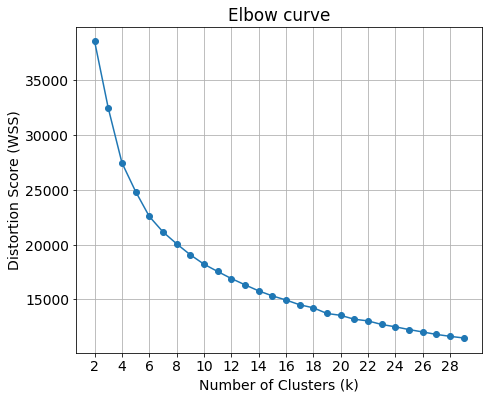

In [709]:
# Plot values of SSE
# plt.ioff()
# plt.ion()
plt.figure(figsize=(16,6))
plt.rcParams.update({'font.size': 14})
plt.subplot(121, title='Elbow curve')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion Score (WSS)')
plt.xticks(range(2, 30, 2))
plt.plot(range(2, 30), distorsions, marker="o")
plt.grid(True)

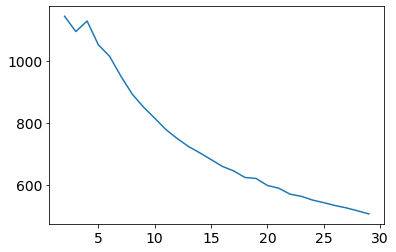

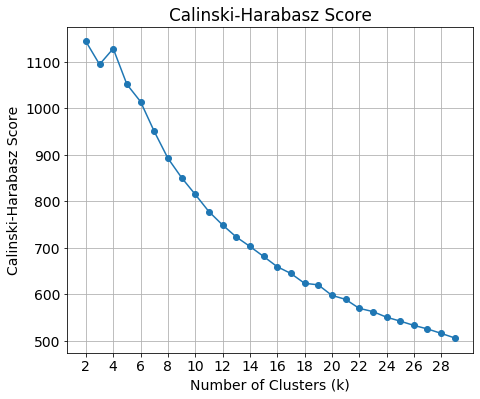

In [710]:
plt.plot(range(2, 30), ch_score_values)

plt.figure(figsize=(16,6))
plt.rcParams.update({'font.size': 14})
plt.subplot(121, title='Calinski-Harabasz Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.xticks(range(2, 30, 2))
plt.plot(range(2, 30), ch_score_values, marker="o")
plt.grid(True)

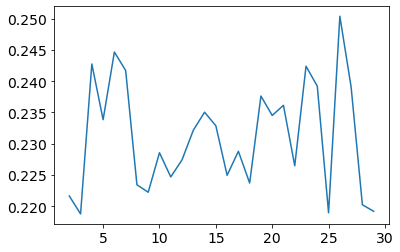

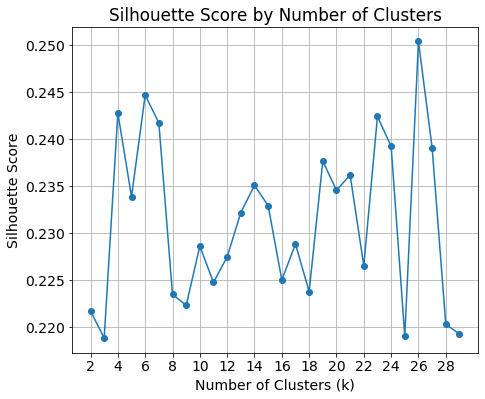

In [711]:
plt.plot(range(2, 30), silhouette_values)


plt.figure(figsize=(16,6))
plt.rcParams.update({'font.size': 14})
plt.subplot(121, title='Silhouette Score by Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 30, 2))
plt.plot(range(2, 30), silhouette_values, marker="o")
plt.grid(True)

In [39]:
ch_score_values = []
silhouette_values = []
distorsions = []
for k in range(3,):
    k_means = KMeans(n_clusters = k)
    k_means.fit(features_scaled_df)
    labels = k_means.labels_
    ch_score_values.append(calinski_harabasz_score(features_scaled_df, labels))
    silhouette_values.append(silhouette_score(features_scaled_df, labels, metric='euclidean'))
    distorsions.append(k_means.inertia_)
print(ch_score_values)
print(silhouette_values)
print(distorsions)

/Users/kathringo/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:90: RuntimeWarning: divide by zero encountered in log
  n_local_trials = 2 + int(np.log(n_clusters))


OverflowError: cannot convert float infinity to integer

In [ ]:
# merging with sic dataframe
co_names_sic = co_names.merge(company_df, how='left', on='name')
co_names_sic_final = co_names_sic.merge(sic_df, how='left', left_on='sic', right_on='SIC Code')
# co_names_sic_final.drop('SIC Code', axis=1, inplace=True)
co_names_sic_final.drop(columns=['adsh', 'countryba', 'form', 'fye', 'period', 'fy', 'fp', 'detail', 'instance',
                                'sic'], inplace=True)
co_names_sic_final.head()
co_names_sic_final.groupby(['group', 'Office']).count()

In [ ]:
labels_series.value_counts()

In [41]:
k_means = KMeans(n_clusters = 6)
k_means.fit(features_scaled_df)
labels = k_means.labels_
print(f"Calinski Harabaz Score: {calinski_harabasz_score(features_scaled_df, labels)}")
print(f"Silhouette Score: {silhouette_score(features_scaled_df, labels, metric='euclidean')}")
print(f"Distorsion Score: {k_means.inertia_}")

Calinski Harabaz Score: 1014.270870990472
Silhouette Score: 0.2446674474322202
Distorsion Score: 22570.268317540173


In [786]:
labels_df = pd.DataFrame(labels)
labels_df.reset_index(inplace=True)
co_names = pd.DataFrame(target)
co_names.reset_index(inplace=True)
labels_df.head()

index  0
0      0  2
1      1  1
2      2  2
3      3  4
4      4  4

In [787]:
co_names = co_names.merge(labels_df, how='inner', on='index')
co_names = co_names.drop(columns='index')
co_names.columns = ['name', 'group']

In [789]:
co_names

name  group
0                                        12 RETECH CORP      2
1                1347 PROPERTY INSURANCE HOLDINGS, INC.      1
2                                     1847 HOLDINGS LLC      2
3                       1895 BANCORP OF WISCONSIN, INC.      4
4                              1ST CONSTITUTION BANCORP      4
5                                       1ST SOURCE CORP      4
6                                    20/20 GLOBAL, INC.      3
7                              22ND CENTURY GROUP, INC.      2
8                                    24/7 KID DOC, INC.      1
9                                              2U, INC.      2
10                                      3D SYSTEMS CORP      2
11                                                3M CO      3
12                                      A. H. BELO CORP      2
13                                   A. M. CASTLE & CO.      2
14                                   A10 NETWORKS, INC.      2
15                                   AAC HOLDINGS, INC.      2
16                                           AAON, INC.      0
17                                          AARON'S INC      3
18                                  ABBOTT LABORATORIES      0
19                                          ABBVIE INC.      0
20                                    ABCO ENERGY, INC.      2
21                             ABEONA THERAPEUTICS INC.      1
22                          ABERCROMBIE & FITCH CO /DE/      0
23                     ABERDEEN STANDARD GOLD ETF TRUST      4
24                ABERDEEN STANDARD PALLADIUM ETF TRUST      4
25                 ABERDEEN STANDARD PLATINUM ETF TRUST      1
26    ABERDEEN STANDARD PRECIOUS METALS BASKET ETF T...      4
27                   ABERDEEN STANDARD SILVER ETF TRUST      4
28                               ABRAXAS PETROLEUM CORP      3
29                                 ABV CONSULTING, INC.      1
30                          ACACIA COMMUNICATIONS, INC.      0
31                    ACACIA DIVERSIFIED HOLDINGS, INC.      2
32                                 ACACIA RESEARCH CORP      2
33                      ACADIA HEALTHCARE COMPANY, INC.      3
34                           ACADIA PHARMACEUTICALS INC      2
35                                  ACADIA REALTY TRUST      3
36                    ACAMAR PARTNERS ACQUISITION CORP.      4
37                          ACCELERATE DIAGNOSTICS, INC      2
38                                      ACCELERIZE INC.      2
39                                 ACCELERON PHARMA INC      2
40                                     ACCO BRANDS CORP      0
41                           ACELRX PHARMACEUTICALS INC      2
42                               ACER THERAPEUTICS INC.      1
43                          ACHIEVE LIFE SCIENCES, INC.      1
44                        ACHILLION PHARMACEUTICALS INC      1
45                                  ACI WORLDWIDE, INC.      3
46                           ACLARIS THERAPEUTICS, INC.      2
47                                   ACM RESEARCH, INC.      3
48                                     ACME UNITED CORP      0
49                                            ACNB CORP      4
50                              ACORDA THERAPEUTICS INC      2
51                                   ACORN ENERGY, INC.      2
52                                  ACQUIRED SALES CORP      1
53                      ACT II GLOBAL ACQUISITION CORP.      4
54                       ACTINIUM PHARMACEUTICALS, INC.      1
55                            ACTIVISION BLIZZARD, INC.      3
56                              ACUSHNET HOLDINGS CORP.      0
57                              ADAIAH DISTRIBUTION INC      5
58                           ADAMAS PHARMACEUTICALS INC      1
59                          ADAMIS PHARMACEUTICALS CORP      2
60                       ADAMS RESOURCES & ENERGY, INC.      3
61                         ADAPTIMMUNE THERAPEUTICS PLC      2
62                        ADAPTIVE BIOTECHNOLOGIES CORP      2
63                 

In [790]:
# merging with sic dataframe
co_names_sic = co_names.merge(company_df, how='left', on='name')
co_names_sic_final = co_names_sic.merge(sic_df, how='left', left_on='sic', right_on='SIC Code')
# co_names_sic_final.drop('SIC Code', axis=1, inplace=True)
co_names_sic_final.drop(columns=['adsh', 'countryba', 'form', 'fye', 'period', 'fy', 'fp', 'detail', 'instance',
                                'sic'], inplace=True)
co_names_sic_final.head()


name  group  SIC Code             Office  \
0                          12 RETECH CORP      2      7371         Technology   
1  1347 PROPERTY INSURANCE HOLDINGS, INC.      1      6331            Finance   
2                       1847 HOLDINGS LLC      2      8742   Trade & Services   
3         1895 BANCORP OF WISCONSIN, INC.      4      6036            Finance   
4                1ST CONSTITUTION BANCORP      4      6035            Finance   

                                  Industry Title  
0         SERVICES-COMPUTER PROGRAMMING SERVICES  
1              FIRE, MARINE & CASUALTY INSURANCE  
2        SERVICES-MANAGEMENT CONSULTING SERVICES  
3  SAVINGS INSTITUTIONS, NOT FEDERALLY CHARTERED  
4       SAVINGS INSTITUTION, FEDERALLY CHARTERED

In [719]:
co_names_sic_final['Office'].unique()

array([' Technology', ' Finance', ' Trade & Services', ' Manufacturing',
       ' Life Sciences', ' Real Estate & Construction',
       ' Energy & Transportation'], dtype=object)

In [819]:
co_names_sic_final[co_names_sic_final['Office'] == ' Finance']

name  group  SIC Code  \
1                1347 PROPERTY INSURANCE HOLDINGS, INC.      1      6331   
3                       1895 BANCORP OF WISCONSIN, INC.      4      6036   
4                              1ST CONSTITUTION BANCORP      4      6035   
5                                       1ST SOURCE CORP      4      6022   
23                     ABERDEEN STANDARD GOLD ETF TRUST      4      6221   
24                ABERDEEN STANDARD PALLADIUM ETF TRUST      4      6221   
25                 ABERDEEN STANDARD PLATINUM ETF TRUST      1      6221   
26    ABERDEEN STANDARD PRECIOUS METALS BASKET ETF T...      4      6221   
27                   ABERDEEN STANDARD SILVER ETF TRUST      4      6221   
49                                            ACNB CORP      4      6022   
82                            ADVANZEON SOLUTIONS, INC.      2      6324   
104                     AFFILIATED MANAGERS GROUP, INC.      3      6282   
105                                           AFLAC INC      4      6321   
154                                  ALLEGHANY CORP /DE      4      6331   
156                         ALLEGIANCE BANCSHARES, INC.      4      6022   
165                              ALLIANCEBERNSTEIN L.P.      3      6282   
171                                       ALLSTATE CORP      4      6331   
172                          ALLSTATE LIFE INSURANCE CO      4      6311   
173                                 ALLY FINANCIAL INC.      4      6022   
189                     ALTEGRIS QIM FUTURES FUND, L.P.      1      6221   
190                  ALTEGRIS WINTON FUTURES FUND, L.P.      1      6221   
207                           AMBAC FINANCIAL GROUP INC      4      6351   
214                                AMERANT BANCORP INC.      4      6021   
218           AMERICA FIRST MULTIFAMILY INVESTORS, L.P.      4      6199   
229          AMERICAN EQUITY INVESTMENT LIFE HOLDING CO      4      6311   
230                                 AMERICAN EXPRESS CO      3      6199   
231                        AMERICAN EXPRESS CREDIT CORP      3      6153   
233                        AMERICAN FINANCIAL GROUP INC      4      6331   
235                    AMERICAN INTERNATIONAL GROUP INC      4      6331   
237                   AMERICAN NATIONAL BANKSHARES INC.      4      6021   
238                 AMERICAN NATIONAL INSURANCE CO /TX/      4      6311   
243                           AMERICAN RIVER BANKSHARES      4      6022   
252                        AMERINST INSURANCE GROUP LTD      3      6399   
253                            AMERIPRISE FINANCIAL INC      4      6282   
254                                      AMERIS BANCORP      4      6022   
255                                       AMERISAFE INC      4      6331   
256                        AMERISERV FINANCIAL INC /PA/      4      6021   
257                                  AMES NATIONAL CORP      4      6021   
287                                        ANTHEM, INC.      3      6324   
289                                             AON PLC      3      6411   
297                        APOLLO GLOBAL MANAGEMENT LLC      3      6282   
331                             ARCH CAPITAL GROUP LTD.      3      6331   
344                                ARES MANAGEMENT CORP      4      6282   
346             ARGO GROUP INTERNATIONAL HOLDINGS, LTD.      4      6361   
348                              ARISTA FINANCIAL CORP.      1      6199   
362                                ARROW FINANCIAL CORP      4      6021   
365              ARTISAN PARTNERS ASSET MANAGEMENT INC.      3      6282   
370                                    AS CAPITAL, INC.      5      6331   
381                  ASSETMARK FINANCIAL HOLDINGS, INC.      3      6282   
383                                ASSOCIATED BANC-CORP      4      6022   
384                      ASSOCIATED CAPITAL GROUP, INC.      4      6211   
385                                        ASSURANT INC      3      6321   
386                    

In [825]:
tech_cos = ['ALPHABET INC.', 'AT&T INC.', 'EVENTBRITE, INC.', 'FACEBOOK INC', 'GODADDY INC.', 'ROKU, INC',
           'SNAP INC', 'SIRIUS XM HOLDINGS INC.', 'SQUARE, INC.', 'T-MOBILE US, INC.', 'TABLEAU SOFTWARE INC',
           'TWITTER, INC.', 'VERIZON COMMUNICATIONS INC', 'XEROX CORP', "UBER TECHNOLOGIES, INC"]
finance_cos = ['AFLAC INC', 'ALLSTATE LIFE INSURANCE CO', 'AMERICAN EXPRESS CO', 'CIGNA CORP', 'CITIGROUP INC',
              'JPMORGAN CHASE & CO', 'MORGAN STANLEY', 'NASDAQ, INC.']

manufacturing = ['ADVANCED MICRO DEVICES INC', 'BOEING CO', 'BEYOND MEAT, INC.', 'COCA-COLA CONSOLIDATED, INC.',
                'GARMIN LTD', 'HARLEY-DAVIDSON, INC.', 'HERSHEY CO', 'KELLOGG CO', 'KRAFT HEINZ CO',
                'LEVI STRAUSS & CO', 'LULULEMON ATHLETICA INC.', 'MATTEL INC /DE/', 'PEPSICO INC',
                'STANLEY BLACK & DECKER, INC.']

trade_services = ['AMAZON COM INC', 'BLUE APRON HOLDINGS, INC.', 'CHEWY, INC.', 'CHIPOTLE MEXICAN GRILL INC',
                  'DOLLAR TREE, INC.', 'EBAY INC', 'ETSY INC', 'GROUPON, INC.', 'GRUBHUB INC.',
                  'NETFLIX INC', 'QVC INC', 'SHAKE SHACK INC.', 'SOTHEBYS', 'TARGET CORP']
# life_sciences = ['3M CO']
# real_estate = ['HILTON WORLDWIDE HOLDINGS INC.', 'REDFIN CORP', 'STARWOOD PROPERTY TRUST, INC.', 'WYNDHAM HOTELS & RESORTS, INC.']
# energy_transport = ['AMERICAN ELECTRIC POWER CO INC', 'PG&E CORP', 'ROYAL CARIBBEAN CRUISES LTD',
#                    'SOUTHWEST AIRLINES CO']

all_industries = tech_cos + finance_cos + manufacturing + trade_services# + life_sciences + real_estate + energy_transport

In [826]:
# num_co_by_group_industry = co_names_sic_final[co_names_sic_final['name'].isin(all_industries)].groupby(['Office', 'group']).count()

In [827]:
by_company = co_names_sic_final[co_names_sic_final['name'].isin(all_industries)]

In [865]:
co_names_sic_final[co_names_sic_final['Office'] == ' Technology'].sort_values('group')

name  group  SIC Code  \
903                            CINCINNATI BELL INC      0      4813   
1234                                 DISH DBS CORP      0      4899   
1235                             DISH NETWORK CORP      0      4841   
1258                         DOUGLAS DYNAMICS, INC      0      3531   
2742                     NATIONAL INSTRUMENTS CORP      0      7372   
2643                       MILACRON HOLDINGS CORP.      0      3559   
2632                                 MIDDLEBY CORP      0      3580   
2814                         NEWPARK RESOURCES INC      0      3533   
2506                              MANITOWOC CO INC      0      3531   
3860                                  TECOGEN INC.      0      3585   
456                       AXCELIS TECHNOLOGIES INC      0      3559   
3872                                    TELOS CORP      0      7373   
797                        CECO ENVIRONMENTAL CORP      0      3564   
3881                            TERADATA CORP /DE/      0      7372   
2433                     LIQTECH INTERNATIONAL INC      0      3590   
2505                   MANITEX INTERNATIONAL, INC.      0      3559   
2871                                      NOW INC.      0      3533   
2915                 OIL STATES INTERNATIONAL, INC      0      3533   
3700                                SPX FLOW, INC.      0      3540   
3400                    RIBBON COMMUNICATIONS INC.      0      7373   
3419                             RINGCENTRAL, INC.      0      7374   
3199                                PROOFPOINT INC      0      7374   
3194                            PROFIRE ENERGY INC      0      3533   
3446                             ROSETTA STONE INC      0      7372   
1012               COMPUTER PROGRAMS & SYSTEMS INC      0      7371   
3070                                   PENTAIR PLC      0      3550   
3512                         SCIENTIFIC GAMES CORP      0      7373   
1095                      CREATIVE REALITIES, INC.      0      7373   
3018                           PAR TECHNOLOGY CORP      0      3578   
2998                            P&F INDUSTRIES INC      0      3540   
2953                                  ONESPAN INC.      0      7373   
669                                 BRUNSWICK CORP      0      3510   
2930                                 OMNICELL, INC      0      3571   
3699                                      SPX CORP      0      3540   
2427                 LINCOLN ELECTRIC HOLDINGS INC      0      3540   
3922                                     TIMKEN CO      0      3562   
3878                                    TENNANT CO      0      3580   
3948                           TPI COMPOSITES, INC      0      3510   
1634               FORUM ENERGY TECHNOLOGIES, INC.      0      3533   
135        ALASKA COMMUNICATIONS SYSTEMS GROUP INC      0      4813   
392                             ASV HOLDINGS, INC.      0      3531   
132                                ALAMO GROUP INC      0      3523   
108                                  AGCO CORP /DE      0      3523   
4225                          VONAGE HOLDINGS CORP      0      4813   
1749               GLOBAL EAGLE ENTERTAINMENT INC.      0      4899   
4272                                 WELBILT, INC.      0      3580   
2048                       ILLINOIS TOOL WORKS INC      0      3560   
2042                                IDEX CORP /DE/      0      3561   
1788                                GORMAN RUPP CO      0      3561   
1791                                     GRACO INC      0      3561   
16                                      AAON, INC.      0      3585   
2017          HYSTER-YALE MATERIALS HANDLING, INC.      0      3537   
4387                       ZEBRA TECHNOLOGIES CORP      0      3560   
1627                                FORTINET, INC.      0      3577   
188                        ALTAIR ENGINEERING INC.      0      7372   
133                       ALARM.COM HOLDINGS, INC.      0      7372   

In [828]:
by_company.sort_values('group')

name  group  SIC Code             Office  \
78      ADVANCED MICRO DEVICES INC      0      3674      Manufacturing   
3841                   TARGET CORP      0      5331   Trade & Services   
3718  STANLEY BLACK & DECKER, INC.      0      3420      Manufacturing   
3077                   PEPSICO INC      0      2080      Manufacturing   
2466      LULULEMON ATHLETICA INC.      0      2300      Manufacturing   
2391             LEVI STRAUSS & CO      0      2300      Manufacturing   
2330                KRAFT HEINZ CO      0      2030      Manufacturing   
2287                    KELLOGG CO      0      2040      Manufacturing   
1878         HARLEY-DAVIDSON, INC.      0      3751      Manufacturing   
1690                    GARMIN LTD      0      3812      Manufacturing   
962   COCA-COLA CONSOLIDATED, INC.      0      2086      Manufacturing   
898                     CIGNA CORP      0      6324            Finance   
1936                    HERSHEY CO      0      2060      Manufacturing   
868                    CHEWY, INC.      0      5961   Trade & Services   
206                 AMAZON COM INC      0      5961   Trade & Services   
2549               MATTEL INC /DE/      2      3942      Manufacturing   
4045        UBER TECHNOLOGIES, INC      2      7372         Technology   
4030                 TWITTER, INC.      2      7370         Technology   
3827          TABLEAU SOFTWARE INC      2      7372         Technology   
1435              EVENTBRITE, INC.      2      7370         Technology   
619                      BOEING CO      2      3721      Manufacturing   
1835                 GROUPON, INC.      2      7311   Trade & Services   
3442                     ROKU, INC      2      4841         Technology   
606      BLUE APRON HOLDINGS, INC.      2      5961   Trade & Services   
3629                      SNAP INC      2      7370         Technology   
3605       SIRIUS XM HOLDINGS INC.      2      4832         Technology   
536              BEYOND MEAT, INC.      2      2000      Manufacturing   
3284                       QVC INC      3      5961   Trade & Services   
3649                      SOTHEBYS      3      7389   Trade & Services   
182                  ALPHABET INC.      3      7370         Technology   
3704                  SQUARE, INC.      3      7372         Technology   
3824             T-MOBILE US, INC.      3      4812         Technology   
3567              SHAKE SHACK INC.      3      5810   Trade & Services   
2779                   NETFLIX INC      3      7841   Trade & Services   
4359                    XEROX CORP      3      3577         Technology   
885     CHIPOTLE MEXICAN GRILL INC      3      5812   Trade & Services   
230            AMERICAN EXPRESS CO      3      6199            Finance   
393                      AT&T INC.      3      4813         Technology   
4177    VERIZON COMMUNICATIONS INC      3      4813         Technology   
1838                  GRUBHUB INC.      3      7389   Trade & Services   
1770                  GODADDY INC.      3      7373         Technology   
1483                  FACEBOOK INC      3      7370         Technology   
1428                      ETSY INC      3      7389   Trade & Services   
1306                      EBAY INC      3      7389   Trade & Services   
1246             DOLLAR TREE, INC.      3      5331   Trade & Services   
2733                  NASDAQ, INC.      3      6200            Finance   
2687                MORGAN STANLEY      4      6211            Finance   
2257           JPMORGAN CHASE & CO      4      6021            Finance   
172     ALLSTATE LIFE INSURANCE CO      4      6311            Finance   
105                      AFLAC INC      4      6321            Finance   
914                  CITIGROUP INC      4      6021            Finance   

                                         Industry Title  
78                     SEMICONDUCTORS & RELATED DEVICES  
3841                              RETAIL-VARIETY STORES  
3718   

In [829]:
num_co_by_group_industry = co_names_sic_final.groupby(['Office', 'group']).count()

In [830]:
num_co_by_group_industry

name  SIC Code  Industry Title
Office                      group                                
 Energy & Transportation    0        66        66              66
                            1        30        30              30
                            2        93        93              93
                            3       306       306             306
                            4        18        18              18
                            5         9         9               9
 Finance                    0         3         3               3
                            1        23        23              23
                            2        17        17              17
                            3       103       103             103
                            4       573       573             573
                            5         3         3               3
 Life Sciences              0       162       162             162
                            1       297       297             297
                            2       373       373             373
                            3       108       108             108
                            4         9         9               9
                            5         8         8               8
 Manufacturing              0       231       231             231
                            1        30        30              30
                            2       164       164             164
                            3        97        97              97
                            4         4         4               4
                            5        14        14              14
 Real Estate & Construction 0        20        20              20
                            1        39        39              39
                            2        56        56              56
                            3       234       234             234
                            4       217       217             217
                            5        25        25              25
 Technology                 0        69        69              69
                            1        22        22              22
                            2       168       168             168
                            3       168       168             168
                            4         3         3               3
                            5        16        16              16
 Trade & Services           0       143       143             143
                            1        44        44              44
                            2       170       170             170
                            3       250       250             250
                            4        14        14              14
                            5        14        14              14

In [831]:
# num_co_by_group_industry = co_names_sic_final.groupby(['Office', 'group']).count()

In [832]:
num_co_by_group_industry = num_co_by_group_industry.reset_index()[['Office', 'group', 'name']]

In [833]:
num_co_by_group_industry.head()

Office  group  name
0   Energy & Transportation      0    66
1   Energy & Transportation      1    30
2   Energy & Transportation      2    93
3   Energy & Transportation      3   306
4   Energy & Transportation      4    18

In [834]:
num_co_by_group_industry.columns = ['Industry', 'Cluster', 'No. Companies']

In [835]:
num_co_by_group_industry

Industry  Cluster  No. Companies
0       Energy & Transportation        0             66
1       Energy & Transportation        1             30
2       Energy & Transportation        2             93
3       Energy & Transportation        3            306
4       Energy & Transportation        4             18
5       Energy & Transportation        5              9
6                       Finance        0              3
7                       Finance        1             23
8                       Finance        2             17
9                       Finance        3            103
10                      Finance        4            573
11                      Finance        5              3
12                Life Sciences        0            162
13                Life Sciences        1            297
14                Life Sciences        2            373
15                Life Sciences        3            108
16                Life Sciences        4              9
17                Life Sciences        5              8
18                Manufacturing        0            231
19                Manufacturing        1             30
20                Manufacturing        2            164
21                Manufacturing        3             97
22                Manufacturing        4              4
23                Manufacturing        5             14
24   Real Estate & Construction        0             20
25   Real Estate & Construction        1             39
26   Real Estate & Construction        2             56
27   Real Estate & Construction        3            234
28   Real Estate & Construction        4            217
29   Real Estate & Construction        5             25
30                   Technology        0             69
31                   Technology        1             22
32                   Technology        2            168
33                   Technology        3            168
34                   Technology        4              3
35                   Technology        5             16
36             Trade & Services        0            143
37             Trade & Services        1             44
38             Trade & Services        2            170
39             Trade & Services        3            250
40             Trade & Services        4             14
41             Trade & Services        5             14

In [836]:
import seaborn as sns

In [837]:
def get_percentage_of_industry(df):
    industries = list(df['Industry'].unique())
    num_by_industry = {}
    for industry in industries:
        total_cos = df.loc[df['Industry']==industry, 'No. Companies'].sum()
        num_by_industry[industry] =  total_cos
    df['percentage_of_industry'] = df.apply(lambda x: x['No. Companies']/num_by_industry[x.Industry], axis=1)
    return df

In [838]:
def get_percentage_of_cluster(df):
    clusters = list(df['Cluster'].unique())
    num_by_cluster = {}
    for cluster in clusters:
        total_cos = df.loc[df['Cluster']==cluster, 'No. Companies'].sum()
        num_by_cluster[cluster] =  total_cos
    df['percentage_of_cluster'] = df.apply(lambda x: x['No. Companies']/num_by_cluster[x.Cluster], axis=1)
    return df

In [839]:
num_co_by_group_industry.columns

Index(['Industry', 'Cluster', 'No. Companies'], dtype='object')

In [840]:
num_co = get_percentage_of_industry(num_co_by_group_industry)

In [841]:
num_co_by_group_industry = get_percentage_of_cluster(num_co_by_group_industry)

In [842]:
num_co_by_group_industry.values

array([[' Energy & Transportation', 0, 66, 0.12643678160919541,
        0.09510086455331412],
       [' Energy & Transportation', 1, 30, 0.05747126436781609,
        0.061855670103092786],
       [' Energy & Transportation', 2, 93, 0.1781609195402299,
        0.0893371757925072],
       [' Energy & Transportation', 3, 306, 0.5862068965517241,
        0.24170616113744076],
       [' Energy & Transportation', 4, 18, 0.034482758620689655,
        0.021479713603818614],
       [' Energy & Transportation', 5, 9, 0.017241379310344827,
        0.10112359550561797],
       [' Finance', 0, 3, 0.004155124653739612, 0.004322766570605188],
       [' Finance', 1, 23, 0.03185595567867036, 0.04742268041237113],
       [' Finance', 2, 17, 0.023545706371191136, 0.01633045148895293],
       [' Finance', 3, 103, 0.14265927977839335, 0.08135860979462875],
       [' Finance', 4, 573, 0.7936288088642659, 0.6837708830548926],
       [' Finance', 5, 3, 0.004155124653739612, 0.033707865168539325],
       [' Li

In [843]:
co_names_sic_final.Office.unique()

array([' Technology', ' Finance', ' Trade & Services', ' Manufacturing',
       ' Life Sciences', ' Real Estate & Construction',
       ' Energy & Transportation'], dtype=object)

In [844]:
co_names_sic_final[co_names_sic_final['name']=='UBER TECHNOLOGIES, INC']

name  group  SIC Code       Office  \
4045  UBER TECHNOLOGIES, INC      2      7372   Technology   

                     Industry Title  
4045  SERVICES-PREPACKAGED SOFTWARE

In [845]:
co_names_sic_final[co_names_sic_final['name'].isin(all_industries)].sort_values(by="group")

name  group  SIC Code             Office  \
78      ADVANCED MICRO DEVICES INC      0      3674      Manufacturing   
3841                   TARGET CORP      0      5331   Trade & Services   
3718  STANLEY BLACK & DECKER, INC.      0      3420      Manufacturing   
3077                   PEPSICO INC      0      2080      Manufacturing   
2466      LULULEMON ATHLETICA INC.      0      2300      Manufacturing   
2391             LEVI STRAUSS & CO      0      2300      Manufacturing   
2330                KRAFT HEINZ CO      0      2030      Manufacturing   
2287                    KELLOGG CO      0      2040      Manufacturing   
1878         HARLEY-DAVIDSON, INC.      0      3751      Manufacturing   
1690                    GARMIN LTD      0      3812      Manufacturing   
962   COCA-COLA CONSOLIDATED, INC.      0      2086      Manufacturing   
898                     CIGNA CORP      0      6324            Finance   
1936                    HERSHEY CO      0      2060      Manufacturing   
868                    CHEWY, INC.      0      5961   Trade & Services   
206                 AMAZON COM INC      0      5961   Trade & Services   
2549               MATTEL INC /DE/      2      3942      Manufacturing   
4045        UBER TECHNOLOGIES, INC      2      7372         Technology   
4030                 TWITTER, INC.      2      7370         Technology   
3827          TABLEAU SOFTWARE INC      2      7372         Technology   
1435              EVENTBRITE, INC.      2      7370         Technology   
619                      BOEING CO      2      3721      Manufacturing   
1835                 GROUPON, INC.      2      7311   Trade & Services   
3442                     ROKU, INC      2      4841         Technology   
606      BLUE APRON HOLDINGS, INC.      2      5961   Trade & Services   
3629                      SNAP INC      2      7370         Technology   
3605       SIRIUS XM HOLDINGS INC.      2      4832         Technology   
536              BEYOND MEAT, INC.      2      2000      Manufacturing   
3284                       QVC INC      3      5961   Trade & Services   
3649                      SOTHEBYS      3      7389   Trade & Services   
182                  ALPHABET INC.      3      7370         Technology   
3704                  SQUARE, INC.      3      7372         Technology   
3824             T-MOBILE US, INC.      3      4812         Technology   
3567              SHAKE SHACK INC.      3      5810   Trade & Services   
2779                   NETFLIX INC      3      7841   Trade & Services   
4359                    XEROX CORP      3      3577         Technology   
885     CHIPOTLE MEXICAN GRILL INC      3      5812   Trade & Services   
230            AMERICAN EXPRESS CO      3      6199            Finance   
393                      AT&T INC.      3      4813         Technology   
4177    VERIZON COMMUNICATIONS INC      3      4813         Technology   
1838                  GRUBHUB INC.      3      7389   Trade & Services   
1770                  GODADDY INC.      3      7373         Technology   
1483                  FACEBOOK INC      3      7370         Technology   
1428                      ETSY INC      3      7389   Trade & Services   
1306                      EBAY INC      3      7389   Trade & Services   
1246             DOLLAR TREE, INC.      3      5331   Trade & Services   
2733                  NASDAQ, INC.      3      6200            Finance   
2687                MORGAN STANLEY      4      6211            Finance   
2257           JPMORGAN CHASE & CO      4      6021            Finance   
172     ALLSTATE LIFE INSURANCE CO      4      6311            Finance   
105                      AFLAC INC      4      6321            Finance   
914                  CITIGROUP INC      4      6021            Finance   

                                         Industry Title  
78                     SEMICONDUCTORS & RELATED DEVICES  
3841                              RETAIL-VARIETY STORES  
3718   

In [563]:
a

Industry  Cluster  No. Companies  percentage_of_industry  \
0            Finance        0              5                    0.62   
1            Finance        2              2                    0.25   
2            Finance        3              1                    0.12   
3      Manufacturing        1              2                    0.14   
4      Manufacturing        3             12                    0.86   
5         Technology        1              6                    0.43   
6         Technology        2              8                    0.57   
7   Trade & Services        1              2                    0.14   
8   Trade & Services        2              9                    0.64   
9   Trade & Services        3              3                    0.21   

   percentage_of_cluster  
0                   1.00  
1                   0.11  
2                   0.06  
3                   0.20  
4                   0.75  
5                   0.60  
6                   0.42  
7                   0.20  
8                   0.47  
9                   0.19

In [743]:
color_scheme = ['paleturquoise', 'cornflowerblue', 'midnightblue', 'mediumpurple',  'palevioletred', 'plum', 'mediumvioletred'] 

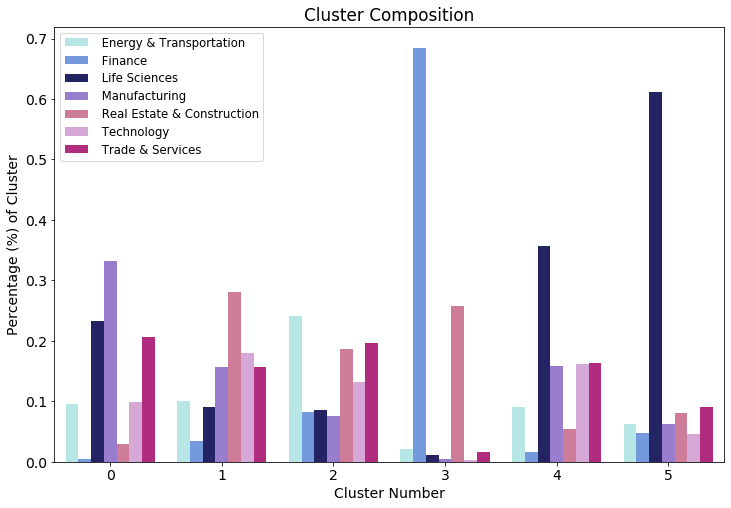

In [820]:
# %matplotlib auto
fig = plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 14})
# plt.subplot(121, title='Elbow curve')

# plt.plot(range(2, 30), distorsions, marker="o")
# plt.grid(True)
sns.barplot(x='Cluster', y='percentage_of_cluster', hue='Industry', data=num_co_by_group_industry, palette=color_scheme);
plt.xlabel('Cluster Number')
plt.ylabel('Percentage (%) of Cluster')
plt.title('Cluster Composition')
# plt.xticks(range(2, 30, 2))
plt.legend(loc='best', fontsize='small')#, bbox_to_anchor=(1.45, 0.8))#, ncol=1)


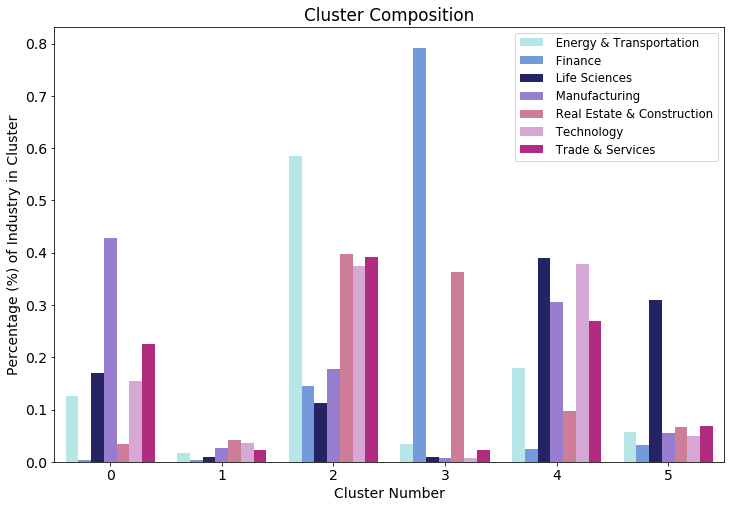

In [818]:
# %matplotlib auto
fig = plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 14})
# plt.subplot(121, title='Elbow curve')

# plt.plot(range(2, 30), distorsions, marker="o")
# plt.grid(True)
sns.barplot(x='Cluster', y='percentage_of_industry', hue='Industry', data=num_co_by_group_industry, palette=color_scheme);
plt.xlabel('Cluster Number')
plt.ylabel('Percentage (%) of Industry in Cluster')
plt.title('Cluster Composition')
# plt.xticks(range(2, 30, 2))
plt.legend(loc='upper right', fontsize='small')#, bbox_to_anchor=(1.45, 0.8))#, ncol=1)


In [794]:
co_names_sic_final[co_names_sic_final['name'].isin(all_industries)].sort_values(by='group')

name  group  SIC Code             Office  \
78      ADVANCED MICRO DEVICES INC      0      3674      Manufacturing   
3841                   TARGET CORP      0      5331   Trade & Services   
3718  STANLEY BLACK & DECKER, INC.      0      3420      Manufacturing   
3077                   PEPSICO INC      0      2080      Manufacturing   
2466      LULULEMON ATHLETICA INC.      0      2300      Manufacturing   
2391             LEVI STRAUSS & CO      0      2300      Manufacturing   
2330                KRAFT HEINZ CO      0      2030      Manufacturing   
2287                    KELLOGG CO      0      2040      Manufacturing   
1936                    HERSHEY CO      0      2060      Manufacturing   
1690                    GARMIN LTD      0      3812      Manufacturing   
962   COCA-COLA CONSOLIDATED, INC.      0      2086      Manufacturing   
898                     CIGNA CORP      0      6324            Finance   
1878         HARLEY-DAVIDSON, INC.      0      3751      Manufacturing   
868                    CHEWY, INC.      0      5961   Trade & Services   
206                 AMAZON COM INC      0      5961   Trade & Services   
2549               MATTEL INC /DE/      2      3942      Manufacturing   
3442                     ROKU, INC      2      4841         Technology   
536              BEYOND MEAT, INC.      2      2000      Manufacturing   
606      BLUE APRON HOLDINGS, INC.      2      5961   Trade & Services   
3605       SIRIUS XM HOLDINGS INC.      2      4832         Technology   
3629                      SNAP INC      2      7370         Technology   
1835                 GROUPON, INC.      2      7311   Trade & Services   
619                      BOEING CO      2      3721      Manufacturing   
1435              EVENTBRITE, INC.      2      7370         Technology   
3827          TABLEAU SOFTWARE INC      2      7372         Technology   
4030                 TWITTER, INC.      2      7370         Technology   
182                  ALPHABET INC.      3      7370         Technology   
3704                  SQUARE, INC.      3      7372         Technology   
3567              SHAKE SHACK INC.      3      5810   Trade & Services   
3824             T-MOBILE US, INC.      3      4812         Technology   
3284                       QVC INC      3      5961   Trade & Services   
3649                      SOTHEBYS      3      7389   Trade & Services   
2779                   NETFLIX INC      3      7841   Trade & Services   
4359                    XEROX CORP      3      3577         Technology   
885     CHIPOTLE MEXICAN GRILL INC      3      5812   Trade & Services   
230            AMERICAN EXPRESS CO      3      6199            Finance   
393                      AT&T INC.      3      4813         Technology   
4177    VERIZON COMMUNICATIONS INC      3      4813         Technology   
1838                  GRUBHUB INC.      3      7389   Trade & Services   
1770                  GODADDY INC.      3      7373         Technology   
1483                  FACEBOOK INC      3      7370         Technology   
1428                      ETSY INC      3      7389   Trade & Services   
1306                      EBAY INC      3      7389   Trade & Services   
1246             DOLLAR TREE, INC.      3      5331   Trade & Services   
2733                  NASDAQ, INC.      3      6200            Finance   
2687                MORGAN STANLEY      4      6211            Finance   
2257           JPMORGAN CHASE & CO      4      6021            Finance   
172     ALLSTATE LIFE INSURANCE CO      4      6311            Finance   
105                      AFLAC INC      4      6321            Finance   
914                  CITIGROUP INC      4      6021            Finance   

                                         Industry Title  
78                     SEMICONDUCTORS & RELATED DEVICES  
3841                              RETAIL-VARIETY STORES  
3718              CUTLERY, HANDTOOLS & GENERAL HARDWARE  
3077                   

4413

In [775]:
analysis_df = df_logged[cols_to_look_at].reset_index()

In [812]:
df_logged.describe()

tag    Assets_  Liabilities_  Equity_    ROE_    ROA_  ProfitMargin_  \
count  4413.00       4413.00  4413.00 4413.00 4413.00        4413.00   
mean     19.44         18.58    16.33   -2.08   -2.65          -2.01   
std       4.20          4.76     7.36    1.79    2.10           1.97   
min      -4.61         -4.61    -4.61  -11.57  -11.27          -9.32   
25%      17.73         16.29    16.04   -3.42   -4.31          -4.08   
50%      20.31         19.53    18.98   -2.60   -3.59          -1.99   
75%      22.01         21.52    20.75    0.00    0.00           0.00   
max      28.87         28.87    27.03    5.58    9.35           6.86   

tag    EquityMultiplier_  FixedAssetsToNetWorth_  DebtToNetWorth_  \
count            4413.00                 4413.00          4413.00   
mean                0.86                    0.22            -2.50   
std                 1.25                    1.75             2.28   
min                -7.07                  -11.82            -6.73   
25%                 0.18                   -0.17            -4.61   
50%                 0.75                    0.29            -4.25   
75%                 1.45                    1.18            -0.20   
max                 6.73                    6.46             6.41   

tag    AssetTurnover_  InventoryTurnover_  DaysReceivables_  QuickRatio_  
count         4413.00             4413.00           4413.00      4413.00  
mean            -2.67               -3.51              1.11         3.78  
std              1.42                2.11              4.80         3.94  
min             -4.80               -4.61             -4.61        -4.61  
25%             -4.38               -4.61             -4.61         3.23  
50%             -2.41               -4.61              4.11         5.00  
75%             -1.51               -4.61              5.37         6.03  
max              2.26                5.29             12.44        19.89

In [791]:
analysis_comparison = co_names_sic_final.merge(analysis_df, how='left', on='name')

In [792]:
analysis_comparison[].head()

name  group  SIC Code             Office  \
0                          12 RETECH CORP      2      7371         Technology   
1  1347 PROPERTY INSURANCE HOLDINGS, INC.      1      6331            Finance   
2                       1847 HOLDINGS LLC      2      8742   Trade & Services   
3         1895 BANCORP OF WISCONSIN, INC.      4      6036            Finance   
4                1ST CONSTITUTION BANCORP      4      6035            Finance   

                                  Industry Title  Assets_  Liabilities_  \
0         SERVICES-COMPUTER PROGRAMMING SERVICES    13.95         16.63   
1              FIRE, MARINE & CASUALTY INSURANCE    19.00         18.60   
2        SERVICES-MANAGEMENT CONSULTING SERVICES    16.78         16.95   
3  SAVINGS INSTITUTIONS, NOT FEDERALLY CHARTERED    20.00         19.87   
4       SAVINGS INSTITUTION, FEDERALLY CHARTERED    20.99         20.88   

   Equity_  ROE_  ROA_  ProfitMargin_  EquityMultiplier_  \
0     0.00 -0.56  0.00           0.00               0.00   
1    17.90  0.00  0.00           0.00               1.10   
2     0.00 -0.99  0.00           0.00               0.00   
3    17.87 -4.62 -4.61          -4.61               2.13   
4    18.72 -3.35 -4.38           3.05               2.27   

   FixedAssetsToNetWorth_  DebtToNetWorth_  AssetTurnover_  \
0                    0.00            -4.61           -1.52   
1                    1.10            -4.61           -4.46   
2                    0.00            -4.61           -0.45   
3                    2.13            -4.61           -4.61   
4                    2.27            -0.24           -4.59   

   InventoryTurnover_  DaysReceivables_  QuickRatio_  
0               -4.61              3.78         8.79  
1               -4.61             -4.61        -4.61  
2                1.25              4.35         6.24  
3               -4.61             -4.61        -4.61  
4               -4.61             -4.61         5.17

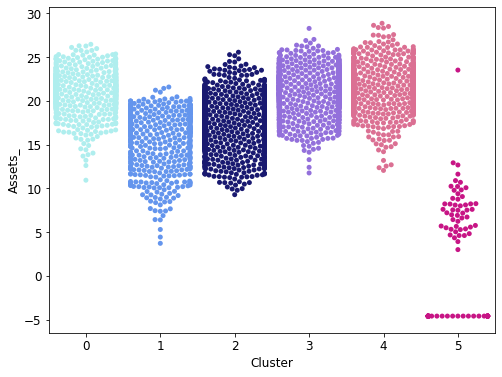

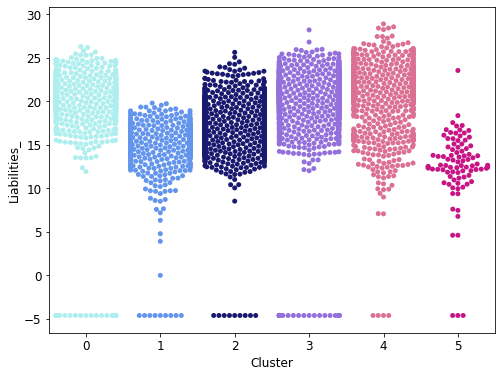

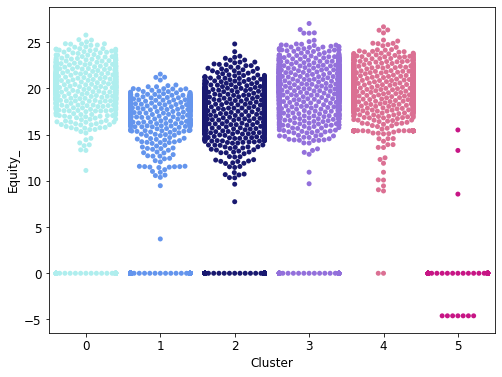

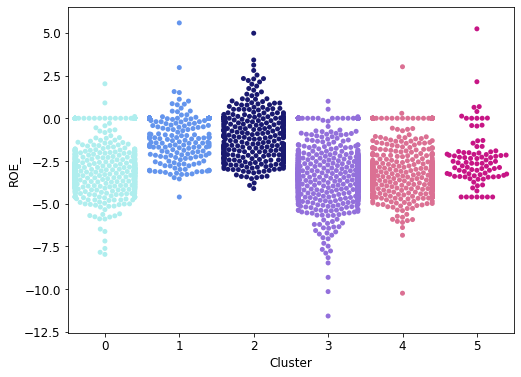

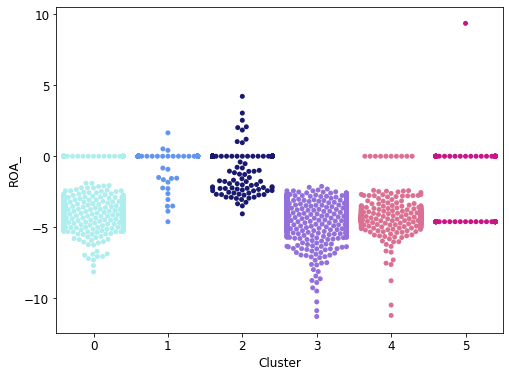

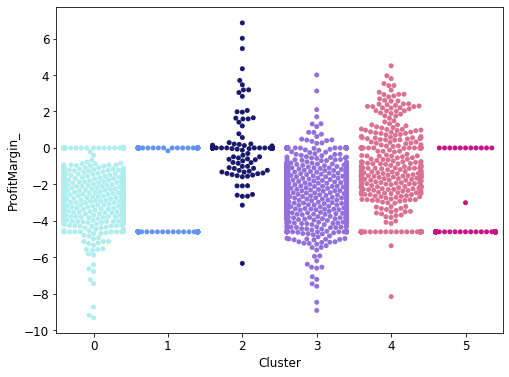

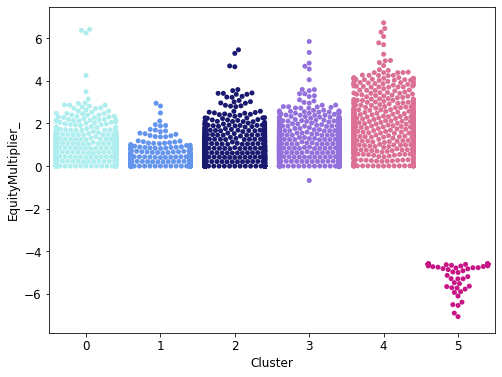

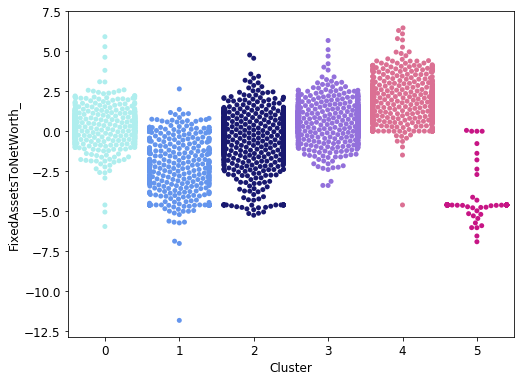

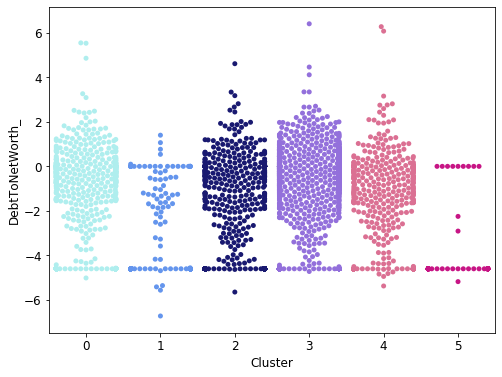

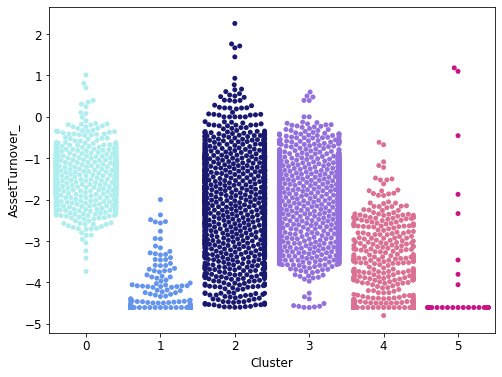

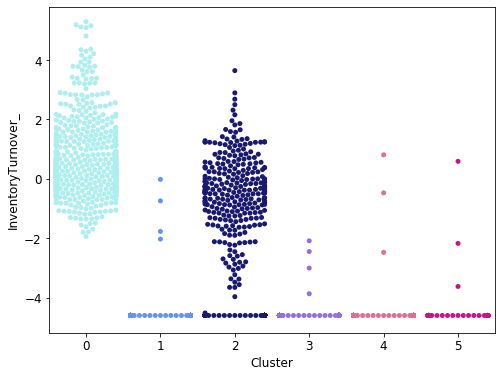

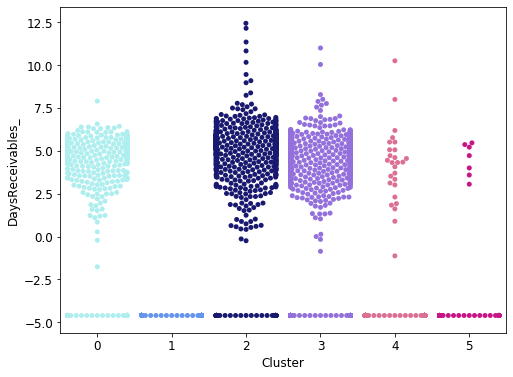

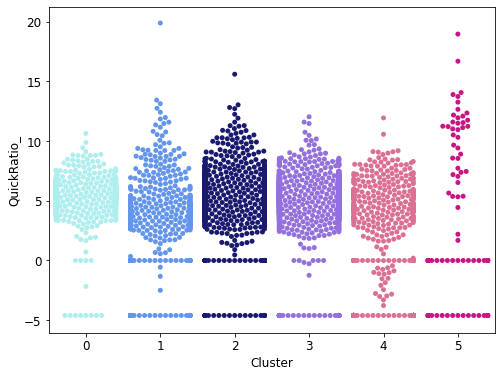

In [991]:
for col in cols_to_look_at:
    fig = plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 12})
    sns.swarmplot(data=analysis_comparison, y=col, x='group', palette=color_scheme)#, showfliers=False)
    plt.xlabel('Cluster')
#     plt.ylabel('Percentage (%) of Industry in Cluster')
#     plt.title('Cluster Composition by Financial Ratio')
    # plt.xticks(range(2, 30, 2))
#     plt.legend(loc='upper right', fontsize='small')#, bbox_to_anchor=(1.45, 0.8))#, ncol=1)
    plt.show()

In [978]:
color_scheme

['paleturquoise',
 'cornflowerblue',
 'midnightblue',
 'mediumpurple',
 'palevioletred',
 'plum',
 'mediumvioletred']

In [988]:
color_scheme = ['paleturquoise',
 'cornflowerblue',
 'midnightblue',
 'mediumpurple',
 'palevioletred',
 'mediumvioletred',
 'mediumvioletred']

In [989]:
analysis_comparison_with_color[['color', 'group', 'name']].groupby(['color', 'group']).count()

name
color           group      
cornflowerblue  1       485
mediumpurple    3      1266
mediumvioletred 5        89
midnightblue    2      1041
paleturquoise   0       694
palevioletred   4       838

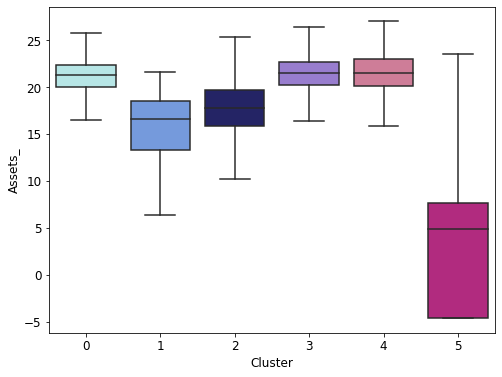

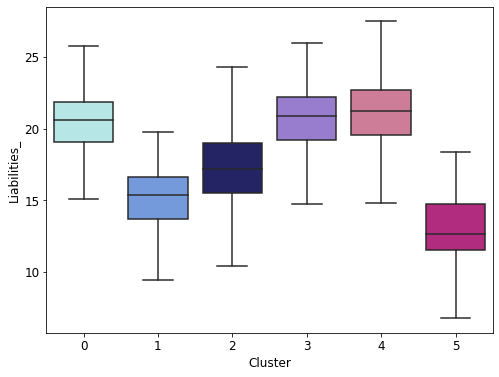

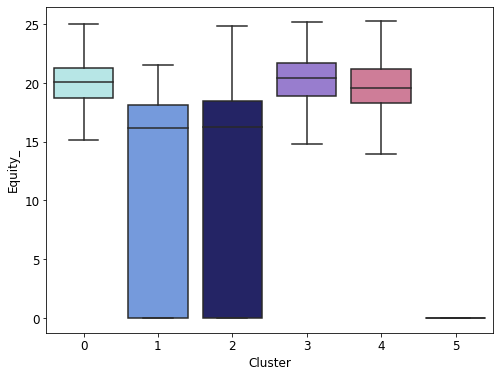

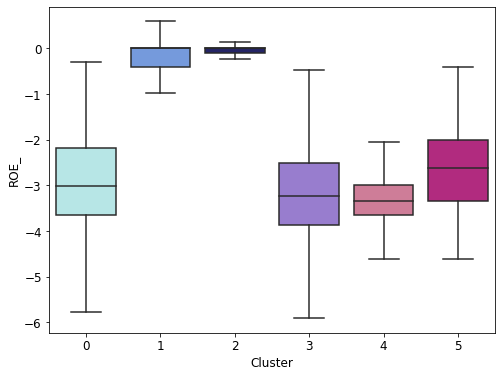

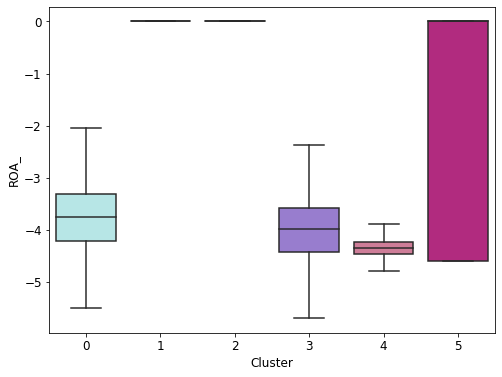

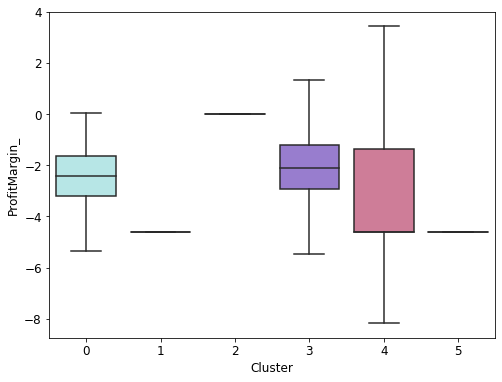

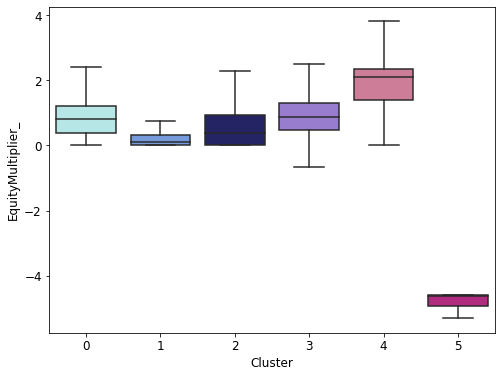

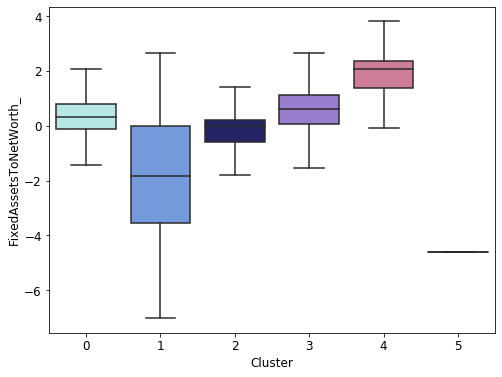

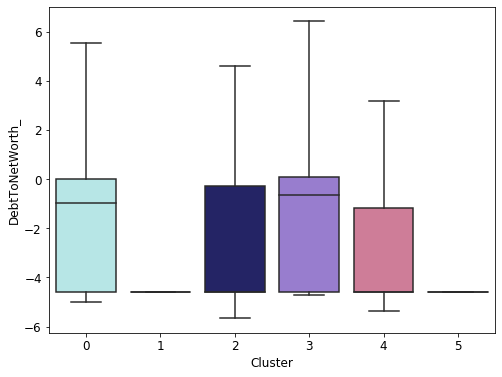

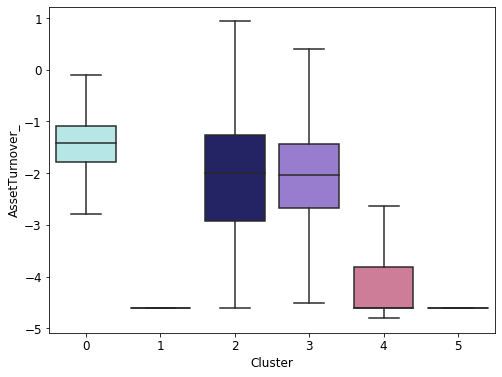

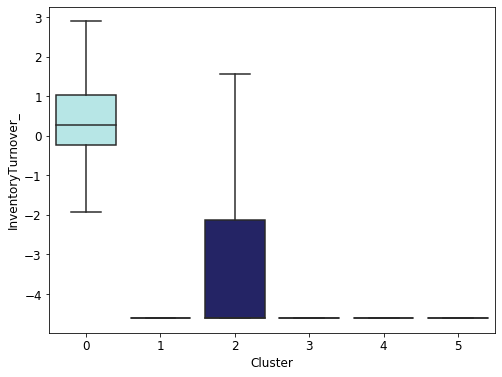

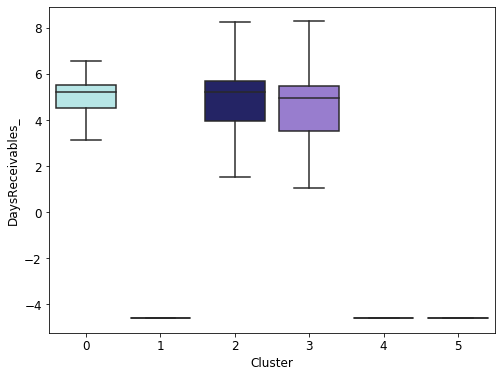

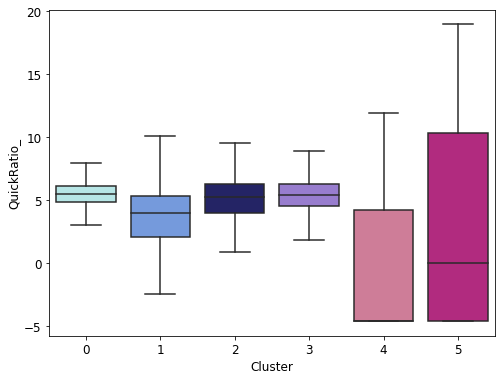

In [990]:
for col in cols_to_look_at:
    fig = plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 12})
    sns.boxplot(data=analysis_comparison, y=col, x='group', palette=color_scheme, showfliers=False)
    plt.xlabel('Cluster')
#     plt.ylabel('Percentage (%) of Industry in Cluster')
#     plt.title('Cluster Composition by Financial Ratio')
    # plt.xticks(range(2, 30, 2))
#     plt.legend(loc='upper right', fontsize='small')#, bbox_to_anchor=(1.45, 0.8))#, ncol=1)
    plt.show()

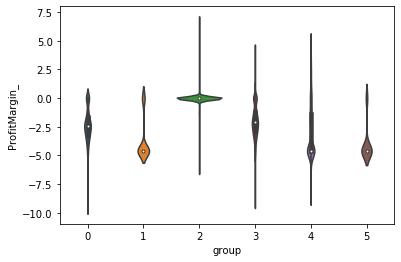

In [878]:
%matplotlib inline
sns.violinplot(data=analysis_comparison, y='ProfitMargin_', x='group')
plt.show();

In [883]:
df.head(1)

tag             AccountsPayableAndAccruedLiabilitiesCurrent  \
name                                                          
12 RETECH CORP                                   1745368.00   

tag             AccountsPayableAndAccruedLiabilitiesCurrentAndNoncurrent  \
name                                                                       
12 RETECH CORP                                               0.00          

tag             AccountsPayableCurrent  AccountsReceivableNet  \
name                                                            
12 RETECH CORP               463636.00                   0.00   

tag             AccountsReceivableNetCurrent  \
name                                           
12 RETECH CORP                      28442.00   

tag             AccruedLiabilitiesAndOtherLiabilities  \
name                                                    
12 RETECH CORP                                   0.00   

tag             AccruedLiabilitiesCurrent     Assets  AssetsCurrent  \
name                                                                  
12 RETECH CORP                  509125.00 1144285.00       93581.00   

tag             AssetsCurrentExcludingRestrictedCash  \
name                                                   
12 RETECH CORP                                  0.00   

tag             AssetsCurrentFairValueDisclosure  AssetsCurrentOther  \
name                                                                   
12 RETECH CORP                              0.00                0.00   

tag             AssetsNoncurrent  CashAndCashEquivalentsAtCarryingValue  \
name                                                                      
12 RETECH CORP              0.00                               25796.00   

tag             CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalents  \
name                                                                            
12 RETECH CORP                                               0.00               

tag             CostOfGoodsAndServicesSold  CostOfSales  \
name                                                      
12 RETECH CORP                        0.00         0.00   

tag             DebtInstrumentCarryingAmount  \
name                                           
12 RETECH CORP                          0.00   

tag             DebtLongtermAndShorttermCombinedAmount  \
name                                                     
12 RETECH CORP                                    0.00   

tag             EmployeeRelatedLiabilitiesCurrent  InventoryFinishedGoods  \
name                                                                        
12 RETECH CORP                               0.00                    0.00   

tag             InventoryGross  InventoryNet  InventoryRawMaterials  \
name                                                                  
12 RETECH CORP            0.00      26376.00                   0.00   

tag             InventoryRawMaterialsNetOfReserves  InventoryWorkInProcess  \
name                                                                         
12 RETECH CORP                                0.00                    0.00   

tag             InventoryWorkInProcessNetOfReserves  Liabilities  \
name                                                               
12 RETECH CORP                                 0.00  16690806.00   

tag             LiabilitiesAndStockholdersEquity  LiabilitiesCurrent  \
name                                                                   
12 RETECH CORP                        1144285.00         16690806.00   

tag             LiabilitiesNoncurrent  LongTermDebt  LongTermDebtCurrent  \
name                                                                       
12 RETECH CORP                   0.00          0.00                 0.00   

tag             LongTermDebtNoncurrent  MarketableSecurities  \
name                                                           
12 RETECH CORP                    0.00  

In [888]:
df_2 = df.reset_index()
df_3 = df_2.reset_index()

In [886]:
labels_with_index = pd.DataFrame(labels).reset_index()
labels_with_index.columns = ['index', 'group']

In [881]:
len(labels)

4413

In [ ]:
pd.Data

In [892]:
df_4 = df_3.merge(labels_with_index, how='inner', on='index')

In [893]:
cols_to_use

['Assets_',
 'ROE_',
 'ROA_',
 'ProfitMargin_',
 'EquityMultiplier_',
 'FixedAssetsToNetWorth_',
 'DebtToNetWorth_',
 'AssetTurnover_',
 'InventoryTurnover_',
 'DaysReceivables_',
 'QuickRatio_']

In [894]:
cols_to_use_2 = cols_to_use + ['group']

In [895]:
df_5 = df_4[cols_to_use_2]

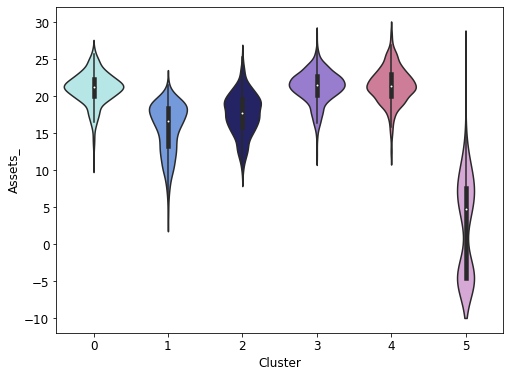

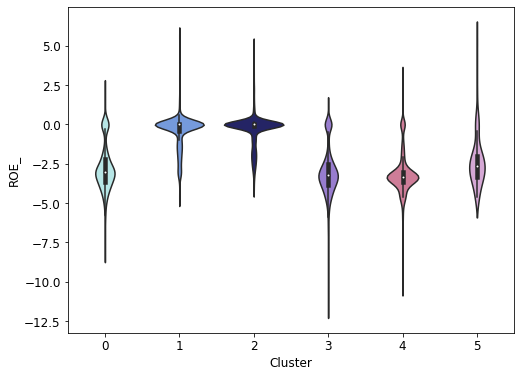

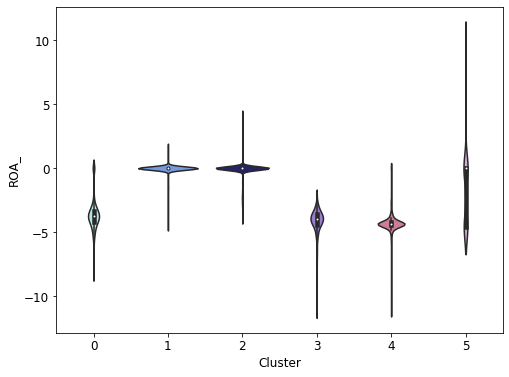

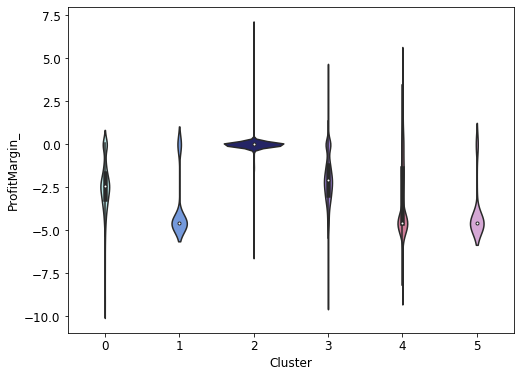

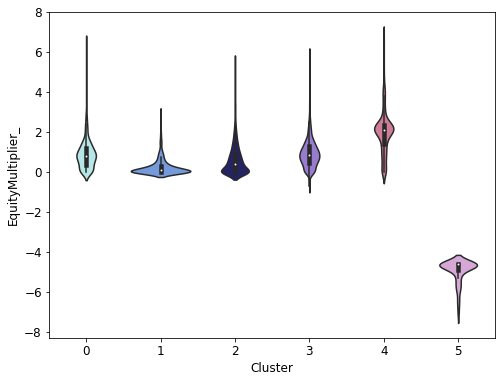

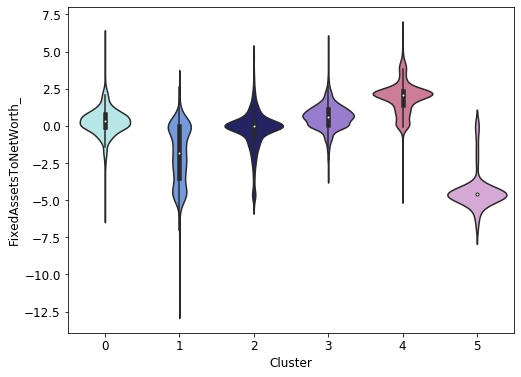

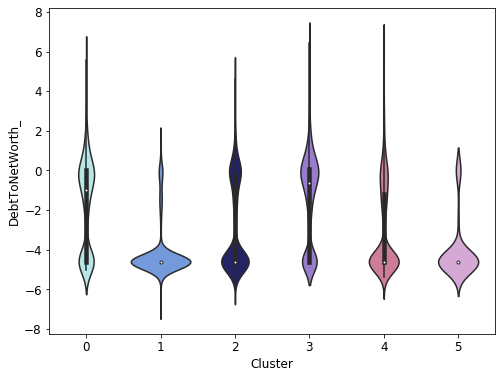

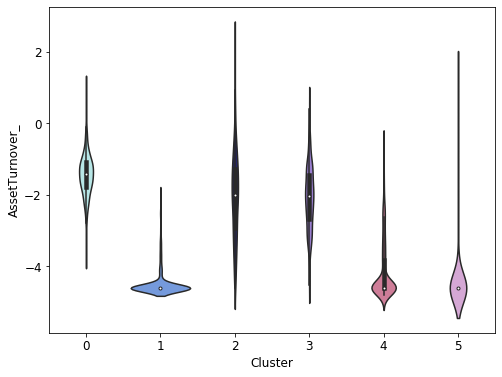

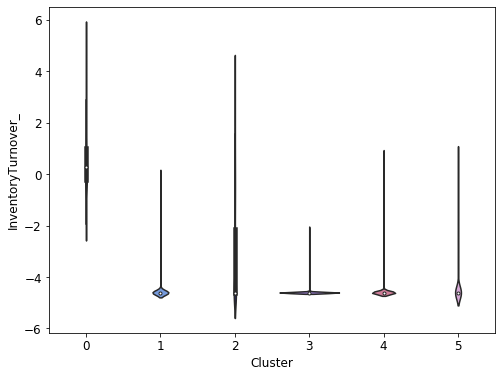

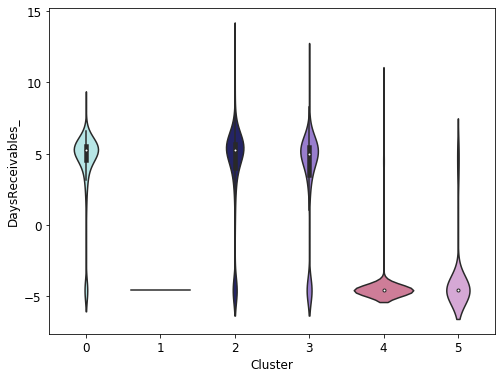

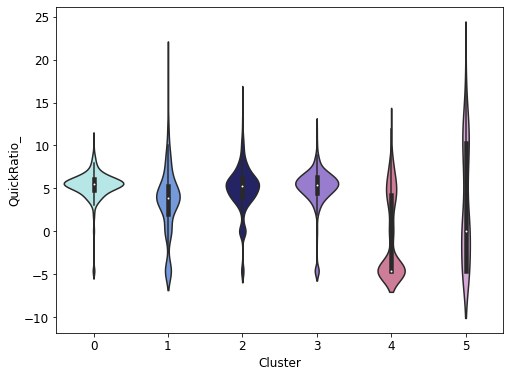

In [897]:
for col in cols_to_use:
    fig = plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 12})
    sns.violinplot(data=analysis_comparison, y=col, x='group', palette=color_scheme)#, showfliers=False)
    plt.xlabel('Cluster')
#     plt.ylabel('Percentage (%) of Industry in Cluster')
#     plt.title('Cluster Composition by Financial Ratio')
    # plt.xticks(range(2, 30, 2))
#     plt.legend(loc='upper right', fontsize='small')#, bbox_to_anchor=(1.45, 0.8))#, ncol=1)
    plt.show()

In [783]:
labels

array([4, 0, 8, ..., 8, 4, 4], dtype=int32)

In [779]:
# labels
features_scaled_df

tag   Assets_  ROE_  ROA_  ProfitMargin_  EquityMultiplier_  \
0       -1.31  0.85  1.26           1.02              -0.69   
1       -0.11  1.16  1.26           1.02               0.19   
2       -0.63  0.61  1.26           1.02              -0.69   
3        0.13 -1.42 -0.94          -1.32               1.01   
4        0.37 -0.71 -0.83           2.57               1.12   
5        0.76 -0.64 -0.79          -1.32               1.01   
6       -1.16 -0.36 -0.44          -0.96               0.21   
7       -0.33  1.16  1.26           1.02              -0.58   
8       -2.05  0.64  1.26          -1.32              -0.69   
9        0.37  1.16  1.26           1.02              -0.34   
10       0.27  1.16  1.26           1.02              -0.29   
11       1.18 -0.01 -0.29           0.05               0.39   
12      -0.12  0.31  0.20           0.51              -0.08   
13       0.06  0.60  1.26           1.02              -0.69   
14      -0.05  1.16  1.26           1.02              -0.02   
15       0.12  1.16  1.26           1.02               1.57   
16       0.05 -0.54 -0.19          -0.06              -0.68   
17       0.58 -0.74 -0.53          -0.46              -0.25   
18       1.31 -0.61 -0.50           0.01              -0.07   
19       1.27  1.16 -0.54          -0.15              -0.69   
20      -1.57  1.01  1.26           1.02              -0.69   
21      -0.13  1.16  1.26          -1.32              -0.37   
22       0.60  1.16 -2.11           1.02               0.30   
23       0.29 -0.19  0.11          -1.32              -0.68   
24      -0.07 -0.18  0.12          -1.32              -0.68   
25       0.18  1.16  1.26          -1.32              -0.68   
26       0.07 -0.34 -0.02          -1.32              -0.68   
27       0.04 -1.09 -0.66          -1.32              -0.68   
28       0.10 -0.21 -0.30           0.48               0.11   
29      -2.43 -0.51  1.26          -1.32              -0.69   
30       0.21 -1.68 -1.11           1.02              -0.50   
31      -1.39  0.91  1.26           1.02              -0.69   
32      -0.07  1.16  1.26           1.02              -0.58   
33       0.76 -0.80 -0.68          -0.32               0.14   
34       0.12  1.16  1.26           1.02              -0.55   
35       0.65 -1.66 -1.00           1.02               0.15   
36       0.03  0.37 -0.78          -1.32               2.61   
37      -0.13  1.16  1.26           1.02               0.76   
38      -0.95  1.80  1.75           3.79              -0.59   
39       0.16  1.16  1.26           1.02              -0.60   
40       0.56 -0.45 -0.56          -0.27               0.38   
41      -0.21  0.95  1.26           1.02              -0.69   
42      -0.51  1.16  1.26          -1.32              -0.54   
43      -0.70  1.16  1.26          -1.32              -0.48   
44      -0.03  1.16  1.26          -1.32              -0.63   
45       0.60 -1.17 -0.86          -0.77               0.26   
46      -0.06  1.16  1.26           1.02              -0.32   
47      -0.20 -0.23 -0.21           0.09              -0.13   
48      -0.21 -0.42 -0.37          -0.28              -0.08   
49       0.43 -0.56 -0.78          -1.32               1.09   
50       0.35  1.16  1.26           1.02              -0.06   
51      -0.91  1.16  1.26           1.02               1.37   
52      -0.91  1.16  1.26          -1.32              -0.67   
53       0.02  0.43 -0.76          -1.32               2.59   
54      -0.61  1.16  1.26          -1.32              -0.42   
55       0.99 -0.68 -0.43           0.31              -0.38   
56       0.45 -0.50 -0.39          -0.18              -0.15   
57      -5.73 -1.41 -0.93          -1.32              -4.37   
58      -0.08  1.16  1.26          -1.32               0.55   
59      -0.42  1.16  1.26           1.02              -0.42   
60       0.02 -1.41 -0.93          -1.32              -0.13   
61      -0.04  1.16  1.26           1.02              -0.49   
62       0.18 -0.37  1.26      

In [616]:
# combos = list(combinations(list(features.columns), 2))
# # graph your scatterplot here
# for combo in combos:
#     plt.scatter(features_scaled_df[combo[0]], features_scaled_df[combo[1]], c=color_scheme)
#     plt.xlabel(combo[0])
#     plt.ylabel(combo[1])
#     plt.show()

ValueError: 'c' argument has 7 elements, which is not acceptable for use with 'x' with size 4413, 'y' with size 4413.

## Visualizing the clusters with PCA

In [617]:
# create principal components 
pca = PCA()
principalComponents = pca.fit_transform(features_scaled_df)

# plt.scatter(pca_df.pc_0, pca_df.pc_1, c=segs)

In [746]:
#create a dataframe with the principal components
pca_columns = []
for i in range(11):
    pca_columns.append('pc_'+str(i))

In [747]:
pca_columns

['pc_0',
 'pc_1',
 'pc_2',
 'pc_3',
 'pc_4',
 'pc_5',
 'pc_6',
 'pc_7',
 'pc_8',
 'pc_9',
 'pc_10']

In [748]:
#graph the clusters by the principal components
pca_df = pd.DataFrame(data = principalComponents, 
                           columns = pca_columns)

In [898]:
# eigenvalues = pca.explained_variance_

In [900]:
eigenvalues = pca.explained_variance_ratio_

In [902]:
eigenvalues[:3].sum()

0.6258522373475761

In [904]:
eigenvalues[:2].sum()

0.4984881451935852

In [749]:
principalComponents

array([[ 2.09850051e+00, -1.33722864e+00,  6.50399426e-01, ...,
        -1.72079403e-03, -3.02438929e-01, -3.94212395e-01],
       [ 9.55663919e-01,  1.78732751e+00,  2.43441577e+00, ...,
         1.07384507e-01, -2.62451914e-01, -4.48602673e-01],
       [ 1.48228900e+00, -2.50367400e+00, -1.60057620e-01, ...,
         3.11883948e-01, -4.50902045e-01, -5.03067912e-01],
       ...,
       [ 9.19450491e-01, -1.77717252e+00, -9.60935828e-01, ...,
         1.48443722e-01, -8.62210468e-03,  1.94413081e-01],
       [ 5.85055610e-01, -1.15304352e+00,  1.56449227e+00, ...,
         2.35900690e-02, -1.15210000e-01, -3.69797867e-01],
       [ 3.48347278e+00, -2.07093871e-01, -8.42863507e-01, ...,
         1.40194131e+00, -5.19774250e-01,  1.89556317e+00]])

In [750]:
labels

array([4, 5, 4, ..., 0, 4, 5], dtype=int32)

In [751]:
labels_series = pd.Series(labels)

In [753]:
len(labels_series.unique())

6

In [754]:
len(color_scheme)

7

In [755]:
color_scheme_labels = ['paleturquoise',
 'cornflowerblue',
 'midnightblue',
 'mediumpurple',
 'palevioletred',
 'mediumvioletred']

In [756]:
len(color_scheme_labels)

6

In [757]:
labels_series_colors = [color_scheme_labels[x] for x in labels_series]

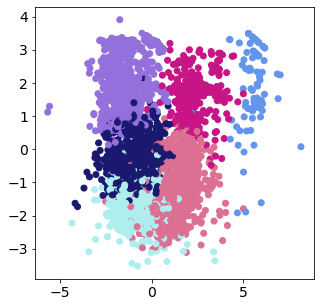

In [758]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(pca_df.pc_0, pca_df.pc_1, c=labels_series_colors)#, cmap=cmap)

In [905]:
len(labels_series_colors)

4413

In [907]:
len(pd.Series(labels_series_colors).unique())

6

In [914]:
labels

array([2, 1, 2, ..., 0, 2, 1], dtype=int32)

In [920]:
color_scheme_labels

['paleturquoise',
 'cornflowerblue',
 'midnightblue',
 'mediumpurple',
 'palevioletred',
 'mediumvioletred']

In [919]:
labels_series_colors

['palevioletred',
 'mediumvioletred',
 'palevioletred',
 'mediumpurple',
 'mediumpurple',
 'mediumpurple',
 'midnightblue',
 'palevioletred',
 'mediumvioletred',
 'palevioletred',
 'palevioletred',
 'midnightblue',
 'palevioletred',
 'palevioletred',
 'palevioletred',
 'palevioletred',
 'paleturquoise',
 'midnightblue',
 'paleturquoise',
 'paleturquoise',
 'palevioletred',
 'mediumvioletred',
 'paleturquoise',
 'mediumpurple',
 'mediumpurple',
 'mediumvioletred',
 'mediumpurple',
 'mediumpurple',
 'midnightblue',
 'mediumvioletred',
 'paleturquoise',
 'palevioletred',
 'palevioletred',
 'midnightblue',
 'palevioletred',
 'midnightblue',
 'mediumpurple',
 'palevioletred',
 'palevioletred',
 'palevioletred',
 'paleturquoise',
 'palevioletred',
 'mediumvioletred',
 'mediumvioletred',
 'mediumvioletred',
 'midnightblue',
 'palevioletred',
 'midnightblue',
 'paleturquoise',
 'mediumpurple',
 'palevioletred',
 'palevioletred',
 'mediumvioletred',
 'mediumpurple',
 'mediumvioletred',
 'midnig

In [927]:
labels_with_index = pd.DataFrame(labels).reset_index()

In [928]:
labels_with_index.columns = ['index', 'num']

In [929]:
labels_with_index

index  num
0         0    2
1         1    1
2         2    2
3         3    4
4         4    4
5         5    4
6         6    3
7         7    2
8         8    1
9         9    2
10       10    2
11       11    3
12       12    2
13       13    2
14       14    2
15       15    2
16       16    0
17       17    3
18       18    0
19       19    0
20       20    2
21       21    1
22       22    0
23       23    4
24       24    4
25       25    1
26       26    4
27       27    4
28       28    3
29       29    1
30       30    0
31       31    2
32       32    2
33       33    3
34       34    2
35       35    3
36       36    4
37       37    2
38       38    2
39       39    2
40       40    0
41       41    2
42       42    1
43       43    1
44       44    1
45       45    3
46       46    2
47       47    3
48       48    0
49       49    4
50       50    2
51       51    2
52       52    1
53       53    4
54       54    1
55       55    3
56       56    0
57       57    5
58       58    1
59       59    2
60       60    3
61       61    2
62       62    2
63       63    3
64       64    2
65       65    2
66       66    1
67       67    3
68       68    2
69       69    2
70       70    3
71       71    0
72       72    2
73       73    0
74       74    2
75       75    3
76       76    3
77       77    0
78       78    0
79       79    1
80       80    0
81       81    2
82       82    2
83       83    2
84       84    1
85       85    1
86       86    5
87       87    3
88       88    1
89       89    1
90       90    4
91       91    4
92       92    4
93       93    1
94       94    4
95       95    0
96       96    2
97       97    2
98       98    3
99       99    2
100     100    3
101     101    1
102     102    0
103     103    1
104     104    3
105     105    4
106     106    4
107     107    4
108     108    0
109     109    2
110     110    2
111     111    2
112     112    1
113     113    2
114     114    4
115     115    3
116     116    1
117     117    2
118     118    1
119     119    1
120     120    2
121     121    3
122     122    3
123     123    3
124     124    3
125     125    2
126     126    3
127     127    3
128     128    2
129     129    2
130     130    2
131     131    2
132     132    0
133     133    0
134     134    3
135     135    0
136     136    0
137     137    3
138     138    4
139     139    1
140     140    2
141     141    1
142     142    1
143     143    1
144     144    0
145     145    3
146     146    3
147     147    0
148     148    1
149     149    3
150     150    2
151     151    2
152     152    1
153     153    1
154     154    4
155     155    0
156     156    4
157     157    3
158     158    0
159     159    4
160     160    1
161     161    2
162     162    0
163     163    3
164     164    3
165     165    3
166     166    3
167     167    0
168     168    3
169     169    1
170     170    2
171     171    4
172     172    4
173     173    4
174     174    2
175     175    1
176     176    2
177     177    2
178     178    1
179     179    2
180     180    0
181     181    1
182     182    3
183     183    2
184     184    2
185     185    1
186     186    5
187     187    3
188     188    0
189     189    1
190     190    1
191     191    3
192     192    3
193     193    2
194     194    1
195     195    3
196     196    2
197     197    0
198     198    0
199     199    4
200     200    3
201     201    2
202     202    1
203     203    5
204     204    1
205     205    0
206     206    0
207     207    4
208     208    1
209     209    3
210     210    3
211     211    4
212     212    4
213     213    3
214     214    4
215     215    3
216     216    0
217     217    2
218     218    4
219     219    3
220     220    3
221     221    0
222     222    2
223     223    2
224     224    3
225     225    2
226     226    4
227     227    0
228     228    3
229     229    4
230     230    3
231     231    3
232     232    4
233     233    4
234     234

In [930]:
labels_with_index['color'] = labels_with_index['num'].apply(lambda x: color_scheme_labels[x])

In [931]:
labels_with_index

index  num            color
0         0    2     midnightblue
1         1    1   cornflowerblue
2         2    2     midnightblue
3         3    4    palevioletred
4         4    4    palevioletred
5         5    4    palevioletred
6         6    3     mediumpurple
7         7    2     midnightblue
8         8    1   cornflowerblue
9         9    2     midnightblue
10       10    2     midnightblue
11       11    3     mediumpurple
12       12    2     midnightblue
13       13    2     midnightblue
14       14    2     midnightblue
15       15    2     midnightblue
16       16    0    paleturquoise
17       17    3     mediumpurple
18       18    0    paleturquoise
19       19    0    paleturquoise
20       20    2     midnightblue
21       21    1   cornflowerblue
22       22    0    paleturquoise
23       23    4    palevioletred
24       24    4    palevioletred
25       25    1   cornflowerblue
26       26    4    palevioletred
27       27    4    palevioletred
28       28    3     mediumpurple
29       29    1   cornflowerblue
30       30    0    paleturquoise
31       31    2     midnightblue
32       32    2     midnightblue
33       33    3     mediumpurple
34       34    2     midnightblue
35       35    3     mediumpurple
36       36    4    palevioletred
37       37    2     midnightblue
38       38    2     midnightblue
39       39    2     midnightblue
40       40    0    paleturquoise
41       41    2     midnightblue
42       42    1   cornflowerblue
43       43    1   cornflowerblue
44       44    1   cornflowerblue
45       45    3     mediumpurple
46       46    2     midnightblue
47       47    3     mediumpurple
48       48    0    paleturquoise
49       49    4    palevioletred
50       50    2     midnightblue
51       51    2     midnightblue
52       52    1   cornflowerblue
53       53    4    palevioletred
54       54    1   cornflowerblue
55       55    3     mediumpurple
56       56    0    paleturquoise
57       57    5  mediumvioletred
58       58    1   cornflowerblue
59       59    2     midnightblue
60       60    3     mediumpurple
61       61    2     midnightblue
62       62    2     midnightblue
63       63    3     mediumpurple
64       64    2     midnightblue
65       65    2     midnightblue
66       66    1   cornflowerblue
67       67    3     mediumpurple
68       68    2     midnightblue
69       69    2     midnightblue
70       70    3     mediumpurple
71       71    0    paleturquoise
72       72    2     midnightblue
73       73    0    paleturquoise
74       74    2     midnightblue
75       75    3     mediumpurple
76       76    3     mediumpurple
77       77    0    paleturquoise
78       78    0    paleturquoise
79       79    1   cornflowerblue
80       80    0    paleturquoise
81       81    2     midnightblue
82       82    2     midnightblue
83       83    2     midnightblue
84       84    1   cornflowerblue
85       85    1   cornflowerblue
86       86    5  mediumvioletred
87       87    3     mediumpurple
88       88    1   cornflowerblue
89       89    1   cornflowerblue
90       90    4    palevioletred
91       91    4    palevioletred
92       92    4    palevioletred
93       93    1   cornflowerblue
94       94    4    palevioletred
95       95    0    paleturquoise
96       96    2     midnightblue
97       97    2     midnightblue
98       98    3     mediumpurple
99       99    2     midnightblue
100     100    3     mediumpurple
101     101    1   cornflowerblue
102     102    0    paleturquoise
103     103    1   cornflowerblue
104     104    3     mediumpurple
105     105    4    palevioletred
106     106    4    palevioletred
107     107    4    palevioletred
108     108    0    paleturquoise
109     109    2     midnightblue
110     110    2     midnightblue
111     111    2     midnightblue
112     112    1   cornflowerblue
113     113    2     midnightblue
114     114    4    palevioletred
115     115    3     mediumpurple
116     116    1   cornflowe

In [933]:
analysis_comparison_with_color = analysis_comparison.reset_index().merge(labels_with_index, on='index')

In [940]:
analysis_comparison_with_color.color.unique()

array(['midnightblue', 'cornflowerblue', 'palevioletred', 'mediumpurple',
       'paleturquoise', 'mediumvioletred'], dtype=object)

In [942]:
analysis_comparison_with_color.loc[analysis_comparison_with_color['color']=='mediumvioletred', ['name', 'group', 'color', 'index']]

name  group            color  \
57                       ADAIAH DISTRIBUTION INC      5  mediumvioletred   
86                          AEDAN FINANCIAL CORP      5  mediumvioletred   
186                        ALR TECHNOLOGIES INC.      5  mediumvioletred   
203                 AMANASU TECHNO HOLDINGS CORP      5  mediumvioletred   
350                ARIZONA GOLD & ONYX MINING CO      5  mediumvioletred   
360                ARRESTAGE INTERNATIONAL, INC.      5  mediumvioletred   
367                                   ARVANA INC      5  mediumvioletred   
370                             AS CAPITAL, INC.      5  mediumvioletred   
389                         ASTIKA HOLDINGS INC.      5  mediumvioletred   
409          ATLANTIC ALLIANCE PARTNERSHIP CORP.      5  mediumvioletred   
414                                ATLANTICA INC      5  mediumvioletred   
429                                AUSCRETE CORP      5  mediumvioletred   
466                         AZZURRA HOLDING CORP      5  mediumvioletred   
518                        BCTC IV ASSIGNOR CORP      5  mediumvioletred   
519                         BCTC V ASSIGNOR CORP      5  mediumvioletred   
569             BIOSCIENCE NEUTRACEUTICALS, INC.      5  mediumvioletred   
617                       BNET MEDIA GROUP, INC.      5  mediumvioletred   
716                          CANCER CAPITAL CORP      5  mediumvioletred   
909                                 CIRTRAN CORP      5  mediumvioletred   
928                 CLEAN COAL TECHNOLOGIES INC.      5  mediumvioletred   
946                               CLOUDWEB, INC.      5  mediumvioletred   
1087                   CPS TECHNOLOGIES CORP/DE/      5  mediumvioletred   
1097                                 CREDEX CORP      5  mediumvioletred   
1223          DIGITAL DEVELOPMENT PARTNERS, INC.      5  mediumvioletred   
1237              DIVERSE DEVELOPMENT GROUP INC.      5  mediumvioletred   
1277               DUKE MOUNTAIN RESOURCES, INC.      5  mediumvioletred   
1283                  DUTCH OVEN GOLD GROUP INC.      5  mediumvioletred   
1308                                  ECARD INC.      5  mediumvioletred   
1342                            EMERALD DATA INC      5  mediumvioletred   
1347                  EMPIRE GLOBAL GAMING, INC.      5  mediumvioletred   
1431                 EUROSPORT ACTIVE WORLD CORP      5  mediumvioletred   
1494                    FAST LANE HOLDINGS, INC.      5  mediumvioletred   
1529                                 FICAAR, INC      5  mediumvioletred   
1615                     FOLKUP DEVELOPMENT INC.      5  mediumvioletred   
1654                            FRIENDABLE, INC.      5  mediumvioletred   
1814             GREEN ENVIROTECH HOLDINGS CORP.      5  mediumvioletred   
1817       GREEN PLANET BIO ENGINEERING CO. LTD.      5  mediumvioletred   
1855              GUOZI ZHONGYU CAPITAL HOLDINGS      5  mediumvioletred   
1947                   HIGH DESERT HOLDING CORP.      5  mediumvioletred   
1997                            HST GLOBAL, INC.      5  mediumvioletred   
2051             IMAGE CHAIN GROUP LIMITED, INC.      5  mediumvioletred   
2059                   IMMUNE THERAPEUTICS, INC.      5  mediumvioletred   
2068                              INCOMING, INC.      5  mediumvioletred   
2080              INFINITY ENERGY RESOURCES, INC      5  mediumvioletred   
2228                           JACC STUDIOS INC.      5  mediumvioletred   
2250              JONES FINANCIAL COMPANIES LLLP      5  mediumvioletred   
2259                          JUDO CAPITAL CORP.      5  mediumvioletred   
2334                       KREIDO BIOFUELS, INC.      5  mediumvioletred   
2366  LAZURITON NANO BIOTECHNOLOGY (U.S.A.) INC.      5  mediumvioletred   
2454                 LOGICQUEST TECHNOLOGY, INC.      5  mediumvioletred   
2484                    MADISON AVE HOLDINGS INC      5  mediumvioletred   
2551                              MAX SOUND CORP      5  mediumvioletred   
2567            

In [938]:
analysis_comparison_with_color.loc[analysis_comparison_with_color['name'].isin(all_industries), ['name', 'group', 'color', 'index']]

name  group          color  index
78      ADVANCED MICRO DEVICES INC      0  paleturquoise     78
105                      AFLAC INC      4  palevioletred    105
172     ALLSTATE LIFE INSURANCE CO      4  palevioletred    172
182                  ALPHABET INC.      3   mediumpurple    182
206                 AMAZON COM INC      0  paleturquoise    206
230            AMERICAN EXPRESS CO      3   mediumpurple    230
393                      AT&T INC.      3   mediumpurple    393
536              BEYOND MEAT, INC.      2   midnightblue    536
606      BLUE APRON HOLDINGS, INC.      2   midnightblue    606
619                      BOEING CO      2   midnightblue    619
868                    CHEWY, INC.      0  paleturquoise    868
885     CHIPOTLE MEXICAN GRILL INC      3   mediumpurple    885
898                     CIGNA CORP      0  paleturquoise    898
914                  CITIGROUP INC      4  palevioletred    914
962   COCA-COLA CONSOLIDATED, INC.      0  paleturquoise    962
1246             DOLLAR TREE, INC.      3   mediumpurple   1246
1306                      EBAY INC      3   mediumpurple   1306
1428                      ETSY INC      3   mediumpurple   1428
1435              EVENTBRITE, INC.      2   midnightblue   1435
1483                  FACEBOOK INC      3   mediumpurple   1483
1690                    GARMIN LTD      0  paleturquoise   1690
1770                  GODADDY INC.      3   mediumpurple   1770
1835                 GROUPON, INC.      2   midnightblue   1835
1838                  GRUBHUB INC.      3   mediumpurple   1838
1878         HARLEY-DAVIDSON, INC.      0  paleturquoise   1878
1936                    HERSHEY CO      0  paleturquoise   1936
2257           JPMORGAN CHASE & CO      4  palevioletred   2257
2287                    KELLOGG CO      0  paleturquoise   2287
2330                KRAFT HEINZ CO      0  paleturquoise   2330
2391             LEVI STRAUSS & CO      0  paleturquoise   2391
2466      LULULEMON ATHLETICA INC.      0  paleturquoise   2466
2549               MATTEL INC /DE/      2   midnightblue   2549
2687                MORGAN STANLEY      4  palevioletred   2687
2733                  NASDAQ, INC.      3   mediumpurple   2733
2779                   NETFLIX INC      3   mediumpurple   2779
3077                   PEPSICO INC      0  paleturquoise   3077
3284                       QVC INC      3   mediumpurple   3284
3442                     ROKU, INC      2   midnightblue   3442
3567              SHAKE SHACK INC.      3   mediumpurple   3567
3605       SIRIUS XM HOLDINGS INC.      2   midnightblue   3605
3629                      SNAP INC      2   midnightblue   3629
3649                      SOTHEBYS      3   mediumpurple   3649
3704                  SQUARE, INC.      3   mediumpurple   3704
3718  STANLEY BLACK & DECKER, INC.      0  paleturquoise   3718
3824             T-MOBILE US, INC.      3   mediumpurple   3824
3827          TABLEAU SOFTWARE INC      2   midnightblue   3827
3841                   TARGET CORP      0  paleturquoise   3841
4030                 TWITTER, INC.      2   midnightblue   4030
4045        UBER TECHNOLOGIES, INC      2   midnightblue   4045
4177    VERIZON COMMUNICATIONS INC      3   mediumpurple   4177
4359                    XEROX CORP      3   mediumpurple   4359

In [934]:
all_industries

['ALPHABET INC.',
 'AT&T INC.',
 'EVENTBRITE, INC.',
 'FACEBOOK INC',
 'GODADDY INC.',
 'ROKU, INC',
 'SNAP INC',
 'SIRIUS XM HOLDINGS INC.',
 'SQUARE, INC.',
 'T-MOBILE US, INC.',
 'TABLEAU SOFTWARE INC',
 'TWITTER, INC.',
 'VERIZON COMMUNICATIONS INC',
 'XEROX CORP',
 'UBER TECHNOLOGIES, INC',
 'AFLAC INC',
 'ALLSTATE LIFE INSURANCE CO',
 'AMERICAN EXPRESS CO',
 'CIGNA CORP',
 'CITIGROUP INC',
 'JPMORGAN CHASE & CO',
 'MORGAN STANLEY',
 'NASDAQ, INC.',
 'ADVANCED MICRO DEVICES INC',
 'BOEING CO',
 'BEYOND MEAT, INC.',
 'COCA-COLA CONSOLIDATED, INC.',
 'GARMIN LTD',
 'HARLEY-DAVIDSON, INC.',
 'HERSHEY CO',
 'KELLOGG CO',
 'KRAFT HEINZ CO',
 'LEVI STRAUSS & CO',
 'LULULEMON ATHLETICA INC.',
 'MATTEL INC /DE/',
 'PEPSICO INC',
 'STANLEY BLACK & DECKER, INC.',
 'AMAZON COM INC',
 'BLUE APRON HOLDINGS, INC.',
 'CHEWY, INC.',
 'CHIPOTLE MEXICAN GRILL INC',
 'DOLLAR TREE, INC.',
 'EBAY INC',
 'ETSY INC',
 'GROUPON, INC.',
 'GRUBHUB INC.',
 'NETFLIX INC',
 'QVC INC',
 'SHAKE SHACK INC.',
 'S

In [1012]:
cos = pca_df.loc[[2257, 4045, 1483]]

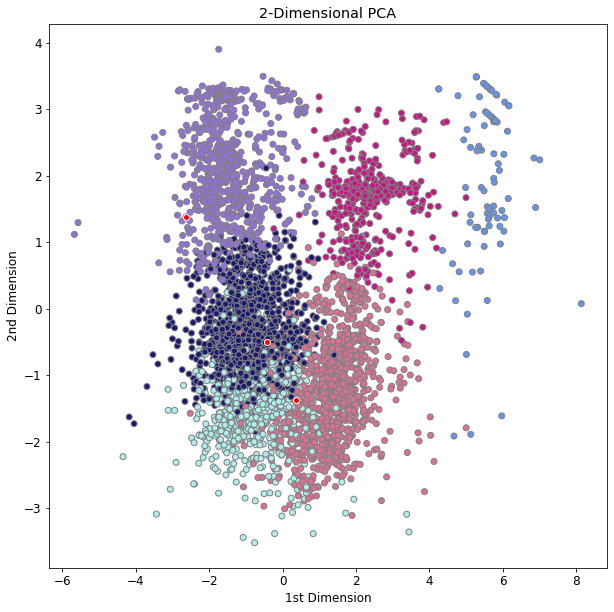

In [1017]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(pca_df.pc_0, pca_df.pc_1, c=labels_series_colors, edgecolor='gray')
plt.scatter(cos.pc_0, cos.pc_1, c='red', edgecolor='white')
plt.xlabel('1st Dimension')
plt.ylabel('2nd Dimension')
plt.title('2-Dimensional PCA')
plt.show()

In [760]:
X

tag   Assets_  ROE_  ROA_  ProfitMargin_  EquityMultiplier_  \
0       -1.31  0.85  1.26           1.02              -0.69   
1       -0.11  1.16  1.26           1.02               0.19   
2       -0.63  0.61  1.26           1.02              -0.69   
3        0.13 -1.42 -0.94          -1.32               1.01   
4        0.37 -0.71 -0.83           2.57               1.12   
5        0.76 -0.64 -0.79          -1.32               1.01   
6       -1.16 -0.36 -0.44          -0.96               0.21   
7       -0.33  1.16  1.26           1.02              -0.58   
8       -2.05  0.64  1.26          -1.32              -0.69   
9        0.37  1.16  1.26           1.02              -0.34   
10       0.27  1.16  1.26           1.02              -0.29   
11       1.18 -0.01 -0.29           0.05               0.39   
12      -0.12  0.31  0.20           0.51              -0.08   
13       0.06  0.60  1.26           1.02              -0.69   
14      -0.05  1.16  1.26           1.02              -0.02   
15       0.12  1.16  1.26           1.02               1.57   
16       0.05 -0.54 -0.19          -0.06              -0.68   
17       0.58 -0.74 -0.53          -0.46              -0.25   
18       1.31 -0.61 -0.50           0.01              -0.07   
19       1.27  1.16 -0.54          -0.15              -0.69   
20      -1.57  1.01  1.26           1.02              -0.69   
21      -0.13  1.16  1.26          -1.32              -0.37   
22       0.60  1.16 -2.11           1.02               0.30   
23       0.29 -0.19  0.11          -1.32              -0.68   
24      -0.07 -0.18  0.12          -1.32              -0.68   
25       0.18  1.16  1.26          -1.32              -0.68   
26       0.07 -0.34 -0.02          -1.32              -0.68   
27       0.04 -1.09 -0.66          -1.32              -0.68   
28       0.10 -0.21 -0.30           0.48               0.11   
29      -2.43 -0.51  1.26          -1.32              -0.69   
30       0.21 -1.68 -1.11           1.02              -0.50   
31      -1.39  0.91  1.26           1.02              -0.69   
32      -0.07  1.16  1.26           1.02              -0.58   
33       0.76 -0.80 -0.68          -0.32               0.14   
34       0.12  1.16  1.26           1.02              -0.55   
35       0.65 -1.66 -1.00           1.02               0.15   
36       0.03  0.37 -0.78          -1.32               2.61   
37      -0.13  1.16  1.26           1.02               0.76   
38      -0.95  1.80  1.75           3.79              -0.59   
39       0.16  1.16  1.26           1.02              -0.60   
40       0.56 -0.45 -0.56          -0.27               0.38   
41      -0.21  0.95  1.26           1.02              -0.69   
42      -0.51  1.16  1.26          -1.32              -0.54   
43      -0.70  1.16  1.26          -1.32              -0.48   
44      -0.03  1.16  1.26          -1.32              -0.63   
45       0.60 -1.17 -0.86          -0.77               0.26   
46      -0.06  1.16  1.26           1.02              -0.32   
47      -0.20 -0.23 -0.21           0.09              -0.13   
48      -0.21 -0.42 -0.37          -0.28              -0.08   
49       0.43 -0.56 -0.78          -1.32               1.09   
50       0.35  1.16  1.26           1.02              -0.06   
51      -0.91  1.16  1.26           1.02               1.37   
52      -0.91  1.16  1.26          -1.32              -0.67   
53       0.02  0.43 -0.76          -1.32               2.59   
54      -0.61  1.16  1.26          -1.32              -0.42   
55       0.99 -0.68 -0.43           0.31              -0.38   
56       0.45 -0.50 -0.39          -0.18              -0.15   
57      -5.73 -1.41 -0.93          -1.32              -4.37   
58      -0.08  1.16  1.26          -1.32               0.55   
59      -0.42  1.16  1.26           1.02              -0.42   
60       0.02 -1.41 -0.93          -1.32              -0.13   
61      -0.04  1.16  1.26           1.02              -0.49   
62       0.18 -0.37  1.26      

In [763]:
label

0

In [44]:
for est in k_means:
    print(est)

TypeError: 'KMeans' object is not iterable

In [43]:
X

NameError: name 'X' is not defined

In [ ]:
k_means = KMeans(n_clusters = 6)
k_means.fit(features_scaled_df)
labels = k_means.labels_

<IPython.core.display.Javascript object>


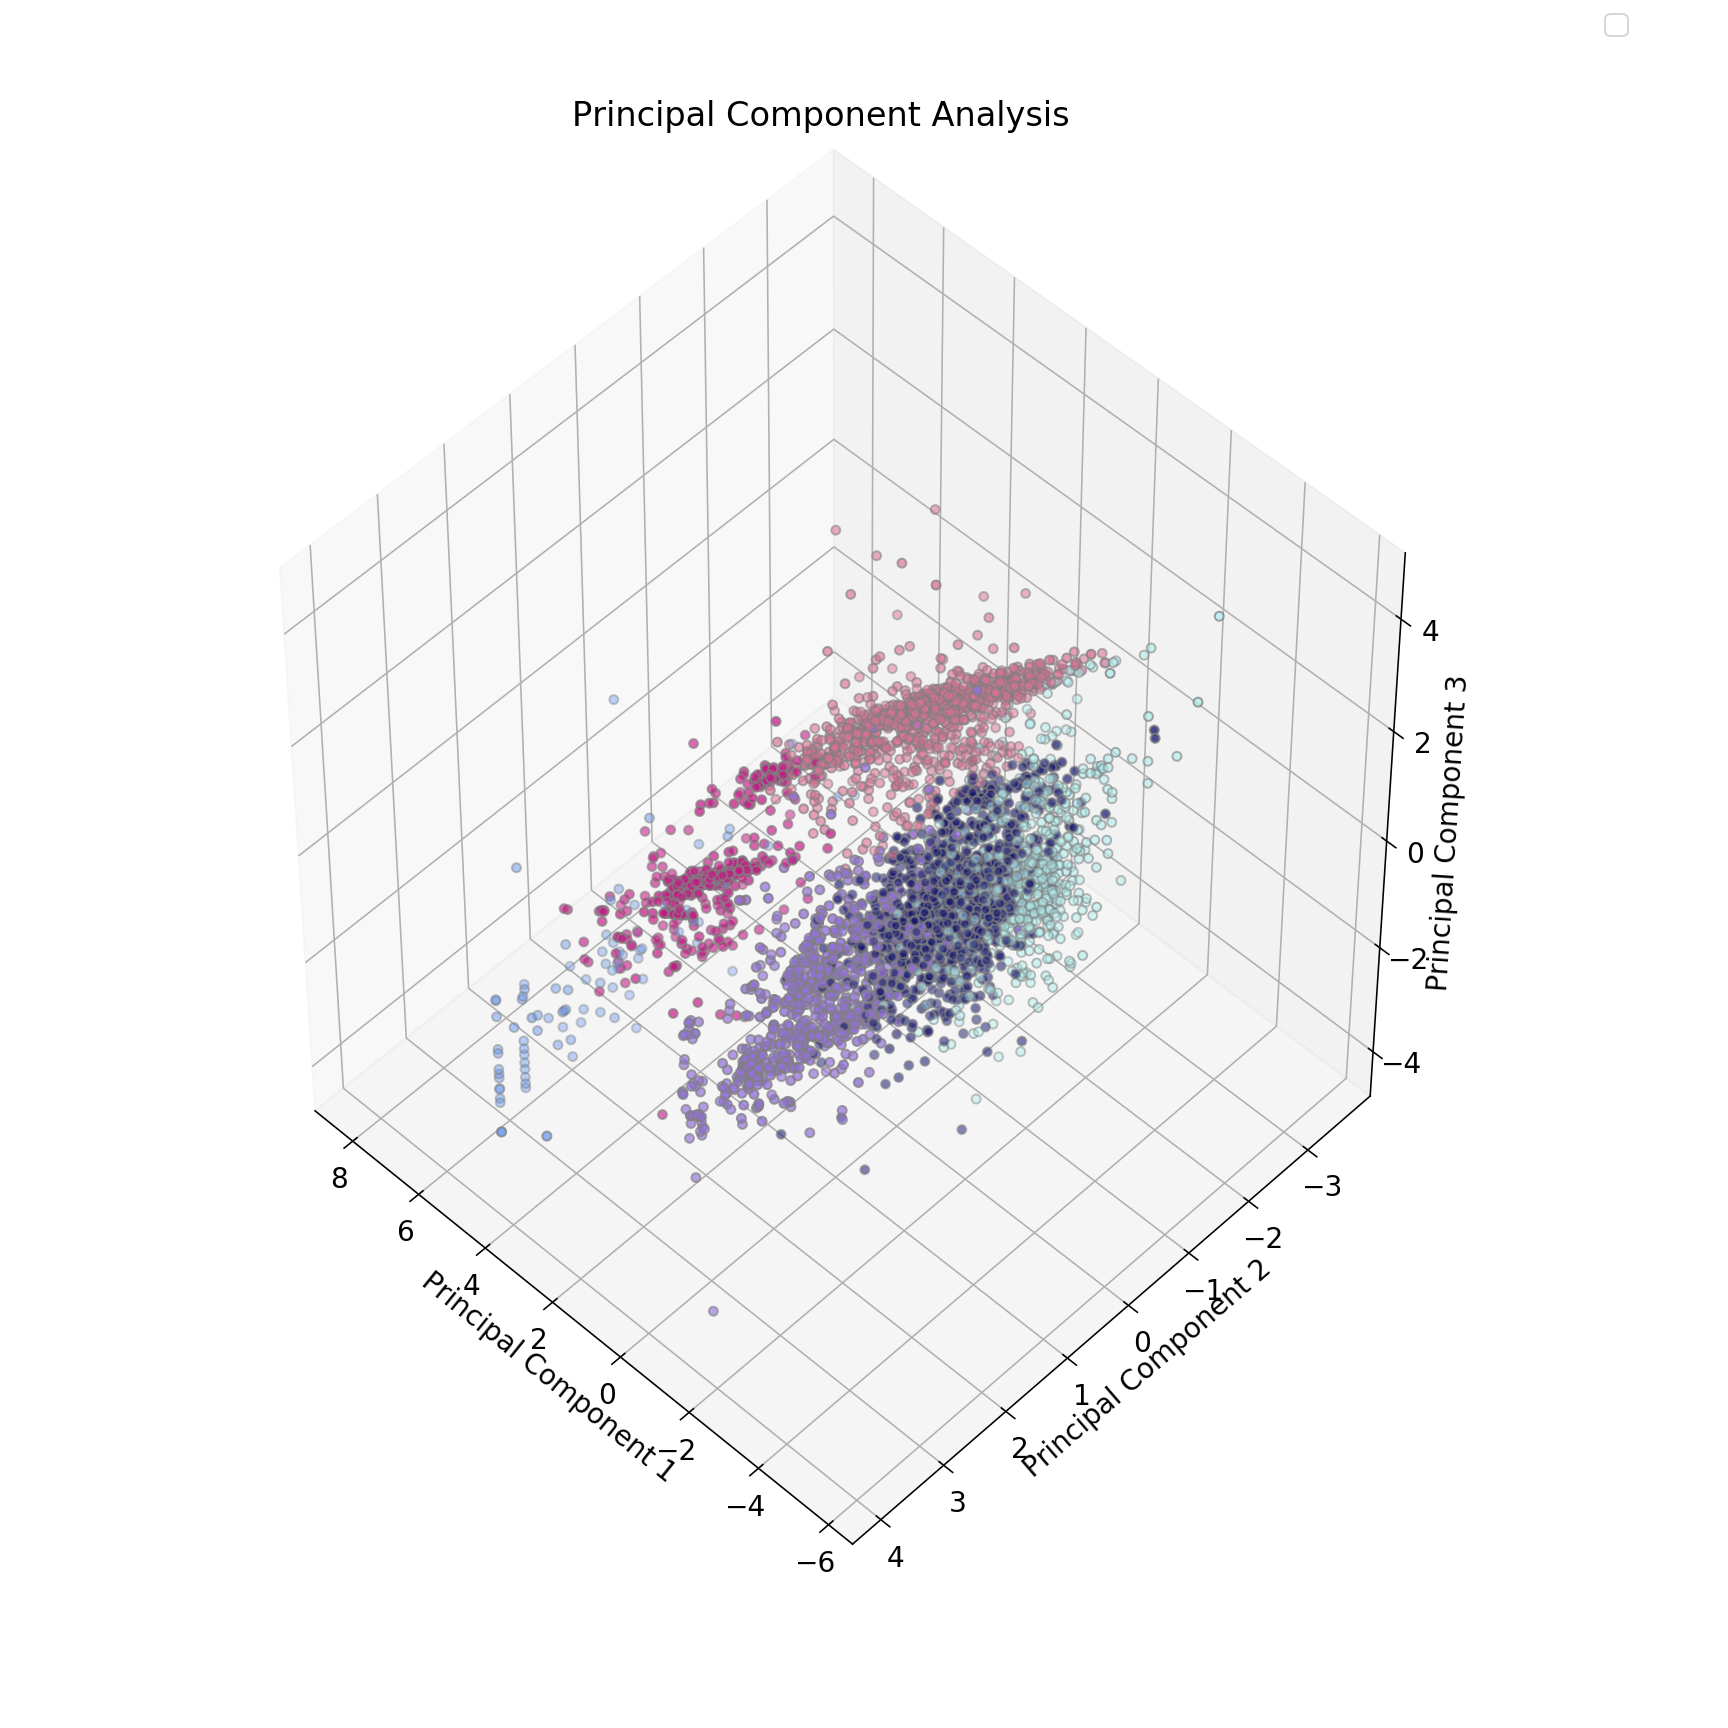

No handles with labels found to put in legend.


In [765]:
# X = features_scaled_df
# %matplotlib widget
%matplotlib notebook


from mpl_toolkits.mplot3d import Axes3D
estimators = [('k_means', KMeans(n_clusters=9))]

fignum = 1
titles = ['Principal Component Analysis']
for name, est in estimators:
    fig = plt.figure(fignum, figsize=(12, 12))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(pca_df.pc_0, pca_df.pc_1, pca_df.pc_2,
               c=labels_series_colors, edgecolor='gray')

#     ax.w_xaxis.set_ticklabels([])
#     ax.w_yaxis.set_ticklabels([])
#     ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    plt.legend()
    ax.set_title(titles[fignum - 1])
    ax.dist = 12
    fignum = fignum + 1

In [643]:
from sklearn.manifold import TSNE

In [644]:
X_embedded = TSNE(n_components=2).fit_transform(principalComponents)
X_embedded.shape

(4413, 2)

In [647]:
X_embedded

array([[ 12.492112, -58.2322  ],
       [ 12.759066, -31.181656],
       [-26.023838, -67.99197 ],
       ...,
       [-44.32083 , -13.607977],
       [ -8.693416, -33.75099 ],
       [ 23.258448, -43.83903 ]], dtype=float32)

In [650]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=labels, legend='full')#, palette=labels_series_colors)


/Users/kathringo/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/art3d.py:794: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/Users/kathringo/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/art3d.py:796: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':
/Users/kathringo/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/art3d.py:798: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir[0] == '-':


In [648]:
len(pd.Series(labels).unique())

9